# Setup

In [1]:
quiet_library <- function(...) {
    suppressPackageStartupMessages(library(...))
}
quiet_library(Seurat)
quiet_library(tidyverse)
quiet_library(H5weaver)
quiet_library(dplyr)
quiet_library(viridis)
quiet_library(harmony)
quiet_library(Nebulosa)
quiet_library(future)
quiet_library(future.apply)
# quiet_library(dittoSeq)
quiet_library("ArchR")
# quiet_library('ggpubr')
quiet_library("rstatix")
quiet_library("chromVAR")
# quiet_library('scCustomize')



                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /                  ||
                ==###########>      /                   ||
                 \\##==......\    /                     ||
            ______ =       =|__ /__                     ||      \\\
        ,--' ,----`-,__ ___/'  --,-`-===================##========>
       \               '        ##_______ _____ ,--,__,=##,__   ///
        ,    __==    ___,-,__,--'#'  ==='      `-'    | ##,-/
        -,____,---'       \\####\\________________,--\\_##,/
           ___      .______        ______  __    __  .______      
          /   \     |   _ 

In [2]:
# Load scMACS and accompanying libraries
quiet_library(MOCHA)
quiet_library(data.table)
quiet_library(GenomicRanges)
quiet_library(plyranges)


In [3]:
packageVersion("MOCHA")


[1] ‘1.1.0’

In [4]:
# Define your annotation package for TxDb object(s)
# and genome-wide annotation
# Here our samples are human using hg38 as a reference.
# For more info: https://bioconductor.org/packages/3.15/data/annotation/
library(TxDb.Hsapiens.UCSC.hg38.refGene)
library(BSgenome.Hsapiens.UCSC.hg38)
library(org.Hs.eg.db)
TxDb <- TxDb.Hsapiens.UCSC.hg38.refGene
Org <- org.Hs.eg.db


Loading required package: GenomicFeatures

Loading required package: AnnotationDbi


Attaching package: ‘AnnotationDbi’


The following object is masked from ‘package:plyranges’:

    select


The following object is masked from ‘package:rstatix’:

    select


The following object is masked from ‘package:dplyr’:

    select


Loading required package: BSgenome

Loading required package: Biostrings

Loading required package: XVector


Attaching package: ‘XVector’


The following object is masked from ‘package:plyr’:

    compact


The following object is masked from ‘package:purrr’:

    compact



Attaching package: ‘Biostrings’


The following object is masked from ‘package:grid’:

    pattern


The following object is masked from ‘package:base’:

    strsplit


Loading required package: BiocIO

Loading required package: rtracklayer


Attaching package: ‘rtracklayer’


The following object is masked from ‘package:BiocIO’:

    FileForFormat






In [5]:
# Check number of cores
future::availableCores()
# Set up parallel processing to run when using 'future' functions
future::plan(strategy = "multicore", workers = future::availableCores() - 3)
options(future.globals.maxSize = 1000 * 1024^5)
# to turn off parallel processing run line below
# future::plan(strategy = "sequential")


system 
    16

In [6]:
# define working path
data_path <- "/home/jupyter/data/preRA_teaseq/EXP-00243"
meta_path <- "/home/jupyter/data/preRA_teaseq/meta_data"
output_path <- "/home/jupyter/data/preRA_teaseq/output_results/cd4_t/atac"
fig_path <- "/home/jupyter/data/preRA_teaseq/EXP-00243/cd4t_cells/Plots"
if (!dir.exists(fig_path)) (dir.create(fig_path, recursive = TRUE))
if (!dir.exists(output_path)) (dir.create(output_path, recursive = TRUE))
# define a project name
proj_name <- "PreRA_teaseq_cd4_t_atac"


In [7]:
# define the color palette to be used
npg_color <- c(
    "#E64B35FF", "#4DBBD5FF", "#00A087FF", "#3C5488FF", "#F39B7FFF",
    "#8491B4FF", "#91D1C2FF", "#DC0000FF", "#7E6148FF", "#B09C85FF"
)
nejm_color <- c("#BC3C29FF", "#0072B5FF", "#E18727FF", "#20854EFF", "#7876B1FF", "#6F99ADFF", "#FFDC91FF", "#EE4C97FF")
jama_color <- c("#374E55FF", "#DF8F44FF", "#00A1D5FF", "#B24745FF", "#79AF97FF", "#6A6599FF", "#80796BFF")
jco_color <- c("#0073C2FF", "#EFC000FF", "#868686FF", "#CD534CFF", "#7AA6DCFF", "#003C67FF", "#8F7700FF")
cluster_colors <- c(
    "#DC050C", "#FB8072", "#1965B0", "#7BAFDE", "#882E72", "#B17BA6", "#FF7F00", "#FDB462", "#E7298A",
    "#E78AC3", "#33A02C", "#B2DF8A", "#55A1B1", "#8DD3C7", "#A6761D", "#E6AB02", "#7570B3", "#BEAED4", "#666666", "#999999",
    "#aa8282", "#d4b7b7", "#8600bf", "#ba5ce3", "#808000", "#aeae5c", "#1e90ff", "#00bfff", "#56ff0d", "#ffff00"
)
cluster_colors_ext <- colorRampPalette(cluster_colors)(36)
options(repr.plot.width = 20, repr.plot.height = 15)


In [8]:
source("/home/jupyter/github/Teaseq-analysis/scRNA_teaseq_ananlysis_helper_functions.r")


In [9]:
# pathway analysis with enrichR
quiet_library(enrichR)
setEnrichrSite("Enrichr")
dbs <- listEnrichrDbs()
# %% codecell|


Connection changed to https://maayanlab.cloud/Enrichr/

Connection is Live!



## Load data

In [10]:
# load the seurat object
# ra_tea_cd4 <- readRDS(file.path(data_path, 'PreRA_teaseq_seurat_cd4_t_filtered_cells_rmBR2024.rds'))


In [11]:
# set ArchR parameters
addArchRThreads(threads = 55)
addArchRGenome("hg38")
set.seed(1221)


Input threads is equal to or greater than ncores minus 1 (15)
Setting cores to ncores minus 2. Set force = TRUE to set above this number!

Setting default number of Parallel threads to 14.

Setting default genome to Hg38.



In [22]:
# load ATAC
# load the ArchR project for CD4 t cells
cd4t_atac <- loadArchRProject(path = "/home/jupyter/data/preRA_teaseq/EXP-00243/cd4t_cells")


Successfully loaded ArchRProject!


                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /                  ||
                ==###########>      /                   ||
                 \\##==......\    /                     ||
            ______ =       =|__ /__                     ||      \\\
        ,--' ,----`-,__ ___/'  --,-`-===================##========>
       \               '        ##_______ _____ ,--,__,=##,__   ///
        ,    __==    ___,-,__,--'#'  ==='      `-'    | ##,-/
        -,____,---'       \\####\\________________,--\\_##,/
           ___      .______        ______  __    __  .____

In [23]:
cd4t_atac



           ___      .______        ______  __    __  .______      
          /   \     |   _  \      /      ||  |  |  | |   _  \     
         /  ^  \    |  |_)  |    |  ,----'|  |__|  | |  |_)  |    
        /  /_\  \   |      /     |  |     |   __   | |      /     
       /  _____  \  |  |\  \\___ |  `----.|  |  |  | |  |\  \\___.
      /__/     \__\ | _| `._____| \______||__|  |__| | _| `._____|
    



class: ArchRProject 
outputDirectory: /home/jupyter/data/preRA_teaseq/EXP-00243/cd4t_cells 
samples(13): EXP-00243-P1_PB00067-03 EXP-00243-P1_PB00073-03 ...
  EXP-00243-P1_PB00501-03 EXP-00243-P1_PB00212-03
sampleColData names(1): ArrowFiles
cellColData names(51): barcodes Sample ... Clusters_0.8 CD4TnaC2toC1
numberOfCells(1): 44806
medianTSS(1): 26.517
medianFrags(1): 5364

In [24]:
# source('/home/jupyter/github/scATAC_Supplements/ArchR_Supplements.R')
# source('/home/jupyter/github/scATAC_Supplements/AlternativeTSS_USage.R')


## peak calls in the all cd4

In [25]:
table(cd4t_atac$clean_l2_cell_types)



        cd4_ctl      cd4_memory       cd4_naive  cd4_temra_like      cd8_memory 
            245           17052           22954               9            1432 
      cd8_naive       cd8_temra         cd8_trm            dn_t            gd_t 
            110             108               9              73              35 
           mait    nk_like_t_nk t_proliferating            treg 
            187              13              35            2544 

In [ ]:
# # call peaks in total CD4 naive cells
# cellPopulations <- cd4t_atac$clean_l2_cell_types %>% unique()
# cellPopLabel <- "t_anno_atac"
numCores <- 59
# Parameters for generating the sample-tile matrices
threshold <- 0.2
groupColumn <- "cohort"
join <- "union"


In [ ]:
cellPopLabel <- "clean_l2_cell_types"
cd4t_atac$cohort %>% unique()
cd4t_atac$clean_l2_cell_types %>% unique()
cellPopulations <- c("cd4_naive", "cd4_memory", "treg")
# cellPopulations <- cd4t_atac$Clusters_0.8 %>% unique()
# cellPopulations = cellPopulations[cellPopulations!='C1']
# cellPopulations


In [ ]:
# cellPopulations
# ?callOpenTiles


In [ ]:
####################################################
# 2. Call open tiles (main peak calling step)
#    Done once for all specified cell populations
####################################################
cd4_tileResults <- MOCHA::callOpenTiles(
    cd4t_atac,
    cellPopLabel = cellPopLabel,
    cellPopulations = cellPopulations,
    TxDb = "TxDb.Hsapiens.UCSC.hg38.refGene",
    Org = "org.Hs.eg.db",
    numCores = numCores,
    outDir = output_path
)


In [ ]:
cd4_tileResults


In [ ]:
# save the tile matrix from mocha
cd4_tileResults %>% saveRDS(file.path(
    output_path,
    paste0(proj_name, "_MOCHA_clean_l2_cell_types_tiles_matrix.rds")
))


In [ ]:
# load the tile matrix from mocha
cd4_tileResults <- readRDS(file.path(
    output_path,
    paste0(proj_name, "_MOCHA_clean_l2_cell_types_tiles_matrix.rds")
))


In [ ]:
plotConsensus(
  tileObject,
  cellPopulations = "All",
  groupColumn = NULL,
  returnPlotList = FALSE,
  returnDFs = FALSE,
  numCores = 1
)


In [ ]:
# call sample tile matrix
SampleTileMatrices <- MOCHA::getSampleTileMatrix(cd4_tileResults,
    numCores = numCores,
    cellPopulations = cellPopulations, groupColumn = groupColumn,
    threshold = threshold, verbose = TRUE
)


In [ ]:
SampleTileMatrices


In [ ]:
# This function can also take any GRanges object
# and add annotations to its metadata.
SampleTileMatricesAnnotated <- MOCHA::annotateTiles(SampleTileMatrices)

# Load a curated motif set from library(chromVARmotifs)
# included with ArchR installation
library(chromVARmotifs)
data(human_pwms_v2)

SampleTileMatricesAnnotated <- MOCHA::addMotifSet(
  SampleTileMatricesAnnotated,
  pwms = human_pwms_v2,
  w = 7 # weight parameter for motifmatchr
)


In [ ]:
SampleTileMatricesAnnotated %>% saveRDS(file.path(
    output_path,
    paste0(proj_name, "_MOCHA_total_clean_l2_cell_types_SampleTileMatrices.rds")
))


In [12]:
# load sample peak matrix in
SampleTileMatricesAnnotated <-
    readRDS(file.path(
        output_path,
        "PreRA_teaseq_cd4_t_atac_MOCHA_total_clean_l2_cell_types_SampleTileMatrices.rds"
    ))
SampleTileMatricesAnnotated


class: RangedSummarizedExperiment 
dim: 671751 12 
metadata(6): summarizedData Genome ... Directory History
assays(3): cd4_naive cd4_memory treg
rownames(671751): chr1:1000000-1000499 chr1:100006000-100006499 ...
  chrX:9997500-9997999 chrY:26409000-26409499
rowData names(5): cd4_naive cd4_memory treg tileType Gene
colnames(12): EXP-00243-P1_PB00060-02 EXP-00243-P1_PB00065-05 ...
  EXP-00243-P1_PB00561-03 EXP-00243-P1_PB00569-04
colData names(9): Sample pool_id ... Sex l1_cell_types

### plot region

In [13]:
# change the genome reference
# library(TxDb.Hsapiens.UCSC.hg38.refGene)
TxDb <- TxDb.Hsapiens.UCSC.hg38.refGene
txList <- suppressWarnings(GenomicFeatures::transcriptsBy(TxDb, by = ("gene")))
names(txList) <- suppressWarnings(AnnotationDbi::mapIds(Org, names(txList), "SYMBOL", "ENTREZID"))


'select()' returned 1:1 mapping between keys and columns



In [14]:
names(txList) %>% str_subset("AL928768")


character(0)

In [ ]:
ArchR::getBlacklist(cd4t_atac) %>% plyranges::filter(seqnames == "chr14" & start > 105583731)


In [ ]:
names(txList)[names(txList) == "3500"]


In [ ]:
cytokines_genes <- c("IFNG-AS1", "IL17A", "IL17F", "IL22", "IFNG", "IL4", "CSF2", "IL12A", "IL10", "IL5", "IL13")

PlotPromoterRegion <- function(gene_name, SampleTileObj, cellPopulations, groupColumn, numCores = 15,
                               sampleSpecific = FALSE) {
    gene_ranges <- txList[[gene_name]] %>%
        as_tibble() %>%
        mutate(gene_range = paste0(seqnames, ":", start - 2000, "-", end + 2000))
    countSE <- MOCHA::extractRegion(
        SampleTileObj = SampleTileObj,
        cellPopulations = cellPopulations,
        region = gene_ranges$gene_range[1],
        groupColumn = groupColumn,
        numCores = numCores,
        sampleSpecific = sampleSpecific
    )
    # add delta
    countSE <- addAccessibilityShift(countSE,
        foreground = paste0(cellPopulations, ".pre-RA"),
        background = paste0(cellPopulations, ".Healthy")
    )
    pdf(file.path(fig_path, paste0(
        "all_cd4_atac_annotate_", cellPopulations,
        gene_name, "_gene_regions.pdf"
    )), width = 16, height = 12)
    p1 <- MOCHA::plotRegion(countSE = countSE, whichGene = gene_name)
    print(p1)
    dev.off()
    return(p1)
}


In [ ]:
gene_ranges <- txList[["IL21"]] %>%
        as_tibble() %>%
        mutate(gene_range = paste0(seqnames, ":", start - 2000, "-", end + 2000))
gene_ranges$gene_range[1]


In [ ]:
marker_genes <- c("PDCD1", "CXCL13", "CXCR5", "IL21")


In [ ]:
p_list <- lapply(marker_genes, PlotPromoterRegion,
        numCores = 50,
        SampleTileObj = SampleTileMatricesAnnotated, cellPopulations = "cd4_memory", groupColumn = "cohort"
)


In [ ]:
p_list[[3]]


In [15]:
SampleTileMatricesAnnotated


class: RangedSummarizedExperiment 
dim: 671751 12 
metadata(6): summarizedData Genome ... Directory History
assays(3): cd4_naive cd4_memory treg
rownames(671751): chr1:1000000-1000499 chr1:100006000-100006499 ...
  chrX:9997500-9997999 chrY:26409000-26409499
rowData names(5): cd4_naive cd4_memory treg tileType Gene
colnames(12): EXP-00243-P1_PB00060-02 EXP-00243-P1_PB00065-05 ...
  EXP-00243-P1_PB00561-03 EXP-00243-P1_PB00569-04
colData names(9): Sample pool_id ... Sex l1_cell_types

In [ ]:
countSE <- MOCHA::extractRegion(
  SampleTileObj = SampleTileMatricesAnnotated,
  cellPopulations = "cd4_memory",
  region = "chr4:122615000-122619999",
  groupColumn = "cohort",
  numCores = 50,
  sampleSpecific = TRUE
)


In [ ]:
# add delta
countSE <- addAccessibilityShift(countSE,
    foreground = "cd4_memory.pre-RA",
    background = "cd4_memory.Healthy"
)


In [ ]:
p1 <- MOCHA::plotRegion(countSE = countSE, whichGene = "IL21")
p1


In [ ]:
head(SummarizedExperiment::assays(countSE)[[1]])


In [ ]:
# p1 <- MOCHA::plotRegion(countSE = countSE, whichGene = 'IL21')
gene_name <- "IL21"
pdf(file.path(fig_path, paste0(
    "cd4_memory_atac_annotate_",
    gene_name, "_gene_regions.pdf"
)), width = 16, height = 12)
MOCHA::plotRegion(countSE = countSE)
dev.off()


In [16]:
# get the gene names and gene ranges
gene_name <- "IL21"
gene_ranges <- txList[[gene_name]] %>%
    as_tibble() %>%
    mutate(gene_range = paste0(seqnames, ":", start - 2000, "-", end + 2000))
gene_ranges


seqnames,start,end,width,strand,tx_id,tx_name,gene_range
<fct>,<int>,<int>,<int>,<fct>,<int>,<chr>,<chr>
chr4,122610108,122621066,10959,-,20591,NM_021803,chr4:122608108-122623066
chr4,122612628,122621057,8430,-,20592,NM_001207006,chr4:122610628-122623057


In [17]:
####################################################
# 5. (Optional) Plot a specific region's coverage.
#    Here we plot coverage at a specific region and
#    gene by infection stage.
####################################################

countSE <- MOCHA::extractRegion(
  SampleTileObj = SampleTileMatricesAnnotated,
  cellPopulations = "cd4_naive",
  region = gene_ranges$gene_range[1],
  groupColumn = "cohort",
  numCores = 62,
  sampleSpecific = FALSE
)


In [ ]:
# add delta
countSE <- addAccessibilityShift(countSE,
    foreground = "cd4_naive.pre-RA",
    background = "cd4_naive.Healthy"
)


In [ ]:
pdf(file.path(fig_path, paste0(
    "cd4_naive_atac_annotate_",
    gene_name, "_gene_regions.pdf"
)), width = 16, height = 12)
MOCHA::plotRegion(countSE = countSE)
dev.off()


## run DAP analysis

In [12]:
# load sample peak matrix in
SampleTileMatricesAnnotated <-
    readRDS(file.path(
        output_path,
        "PreRA_teaseq_cd4_t_atac_MOCHA_total_clean_l2_cell_types_SampleTileMatrices.rds"
    ))
SampleTileMatricesAnnotated


class: RangedSummarizedExperiment 
dim: 671751 12 
metadata(6): summarizedData Genome ... Directory History
assays(3): cd4_naive cd4_memory treg
rownames(671751): chr1:1000000-1000499 chr1:100006000-100006499 ...
  chrX:9997500-9997999 chrY:26409000-26409499
rowData names(5): cd4_naive cd4_memory treg tileType Gene
colnames(12): EXP-00243-P1_PB00060-02 EXP-00243-P1_PB00065-05 ...
  EXP-00243-P1_PB00561-03 EXP-00243-P1_PB00569-04
colData names(9): Sample pool_id ... Sex l1_cell_types

In [13]:
rowData(SampleTileMatricesAnnotated)$cd4_naive %>% table()


.
 FALSE   TRUE 
143046 528705 

### run DAP analysis for cd4 naive

In [12]:
# replace NA as 0
cd4n_counts <- assay(SampleTileMatricesAnnotated, "cd4_naive") %>% as.data.frame()
cd4n_counts[is.na(cd4n_counts)] <- 0
assay(SampleTileMatricesAnnotated, "cd4_naive") <- cd4n_counts %>% as.matrix()


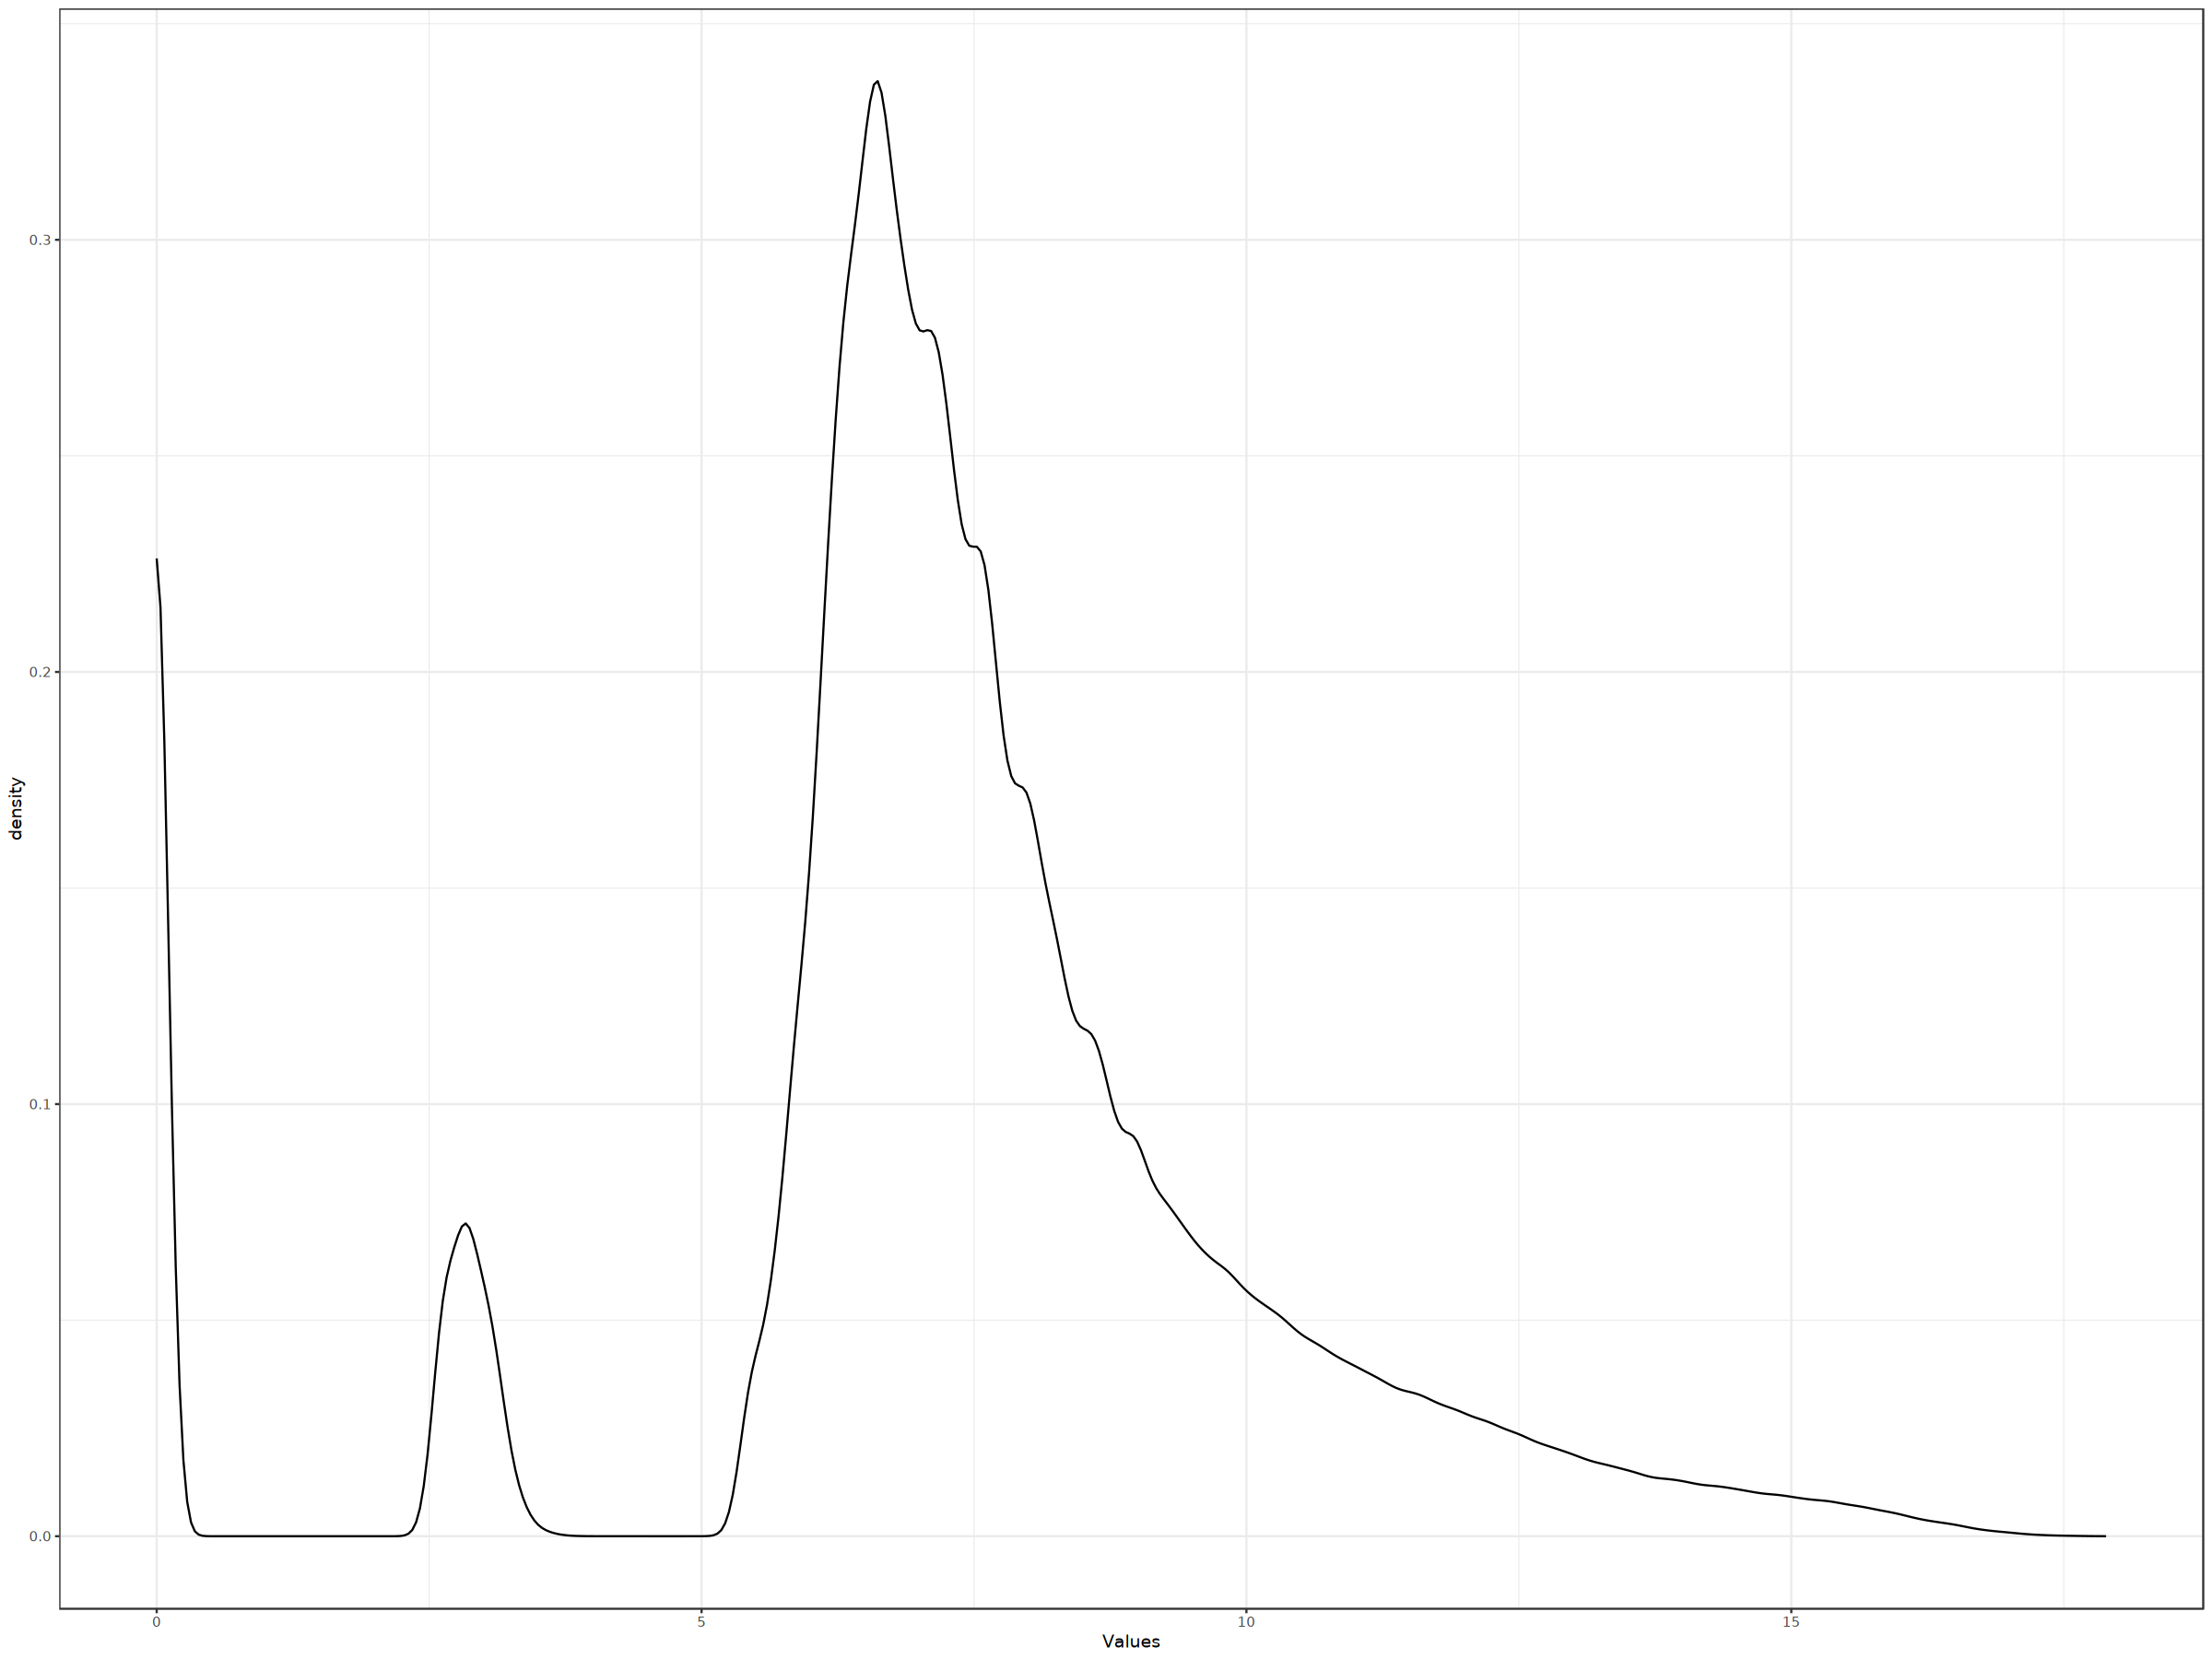

In [14]:
plotIntensityDistribution(
  SampleTileMatricesAnnotated,
  "cd4_naive",
  returnDF = FALSE,
  density = TRUE
)


In [15]:
####################################################
# 5. Get differential accessibility for specific
#    cell populations. Here we are comparing MAIT
#    cells between samples where our groupColumn
#    "COVID_status" is Positive (our foreground)
#    to Negative samples (our background).
####################################################
threshold <- 0.2
groupColumn <- "cohort"
join <- "union"
numCores <- 15
outputGRanges <- TRUE
cd4na_diff <- MOCHA::getDifferentialAccessibleTiles(
    SampleTileObj = SampleTileMatricesAnnotated,
    cellPopulation = "cd4_naive",
    groupColumn = groupColumn,
    foreground = "pre-RA",
    background = "Healthy",
    fdrToDisplay = 0.2,
    signalThreshold = 14,
    minZeroDiff = 0.5,
    outputGRanges = TRUE,
    numCores = numCores
)


In [60]:
# SampleTileMatricesAnnotated_diff <- subsetByOverlaps(SampleTileMatricesAnnotated,
#                                                    cd4na_diff[(!is.na(elementMetadata(cd4na_diff)[,'FDR']))])


In [16]:
cd4na_diff <- annotateTiles(cd4na_diff, TxDb = TxDb, Org = Org)


'select()' returned 1:1 mapping between keys and columns



In [19]:
cd4na_diff %>%
    as_tibble() %>%
    filter(FDR < 0.1 & P_value < 0.05) %>%
    group_by(tileType) %>%
    tally()


tileType,n
<chr>,<int>
Distal,859
Promoter,2300


In [18]:
# save the DAP results
cd4na_diff %>% saveRDS(file.path(output_path, paste0(proj_name, "cd4_naive_preRAvshealthy_DAPs_signal14.rds")))


In [1]:
# load the DAP results
cd4na_diff <- readRDS(file.path(
    "/home/jupyter/data/preRA_teaseq/output_results/cd4_t",
    "PreRA_teaseq_cd4_t_cd4_naive_preRAvshealthy_DAPs.rds"
))


In [21]:
cd4na_diff


GRanges object with 528705 ranges and 15 metadata columns:
           seqnames              ranges strand |                   Tile
              <Rle>           <IRanges>  <Rle> |            <character>
       [1]     chr1     1000000-1000499      * |   chr1:1000000-1000499
       [2]     chr1 100006000-100006499      * | chr1:100006000-10000..
       [3]     chr1 100023500-100023999      * | chr1:100023500-10002..
       [4]     chr1 100024500-100024999      * | chr1:100024500-10002..
       [5]     chr1 100028000-100028499      * | chr1:100028000-10002..
       ...      ...                 ...    ... .                    ...
  [528701]     chrX     9996000-9996499      * |   chrX:9996000-9996499
  [528702]     chrX     9996500-9996999      * |   chrX:9996500-9996999
  [528703]     chrX     9997000-9997499      * |   chrX:9997000-9997499
  [528704]     chrX     9997500-9997999      * |   chrX:9997500-9997999
  [528705]     chrY   26409000-26409499      * | chrY:26409000-26409499
     

In [32]:
cd4na_diff %>%
    as_tibble() %>%
    filter(FDR < 0.1 & P_value < 0.05) %>%
    group_by(tileType) %>%
    tally()


tileType,n
<chr>,<int>
Distal,859
Promoter,2300


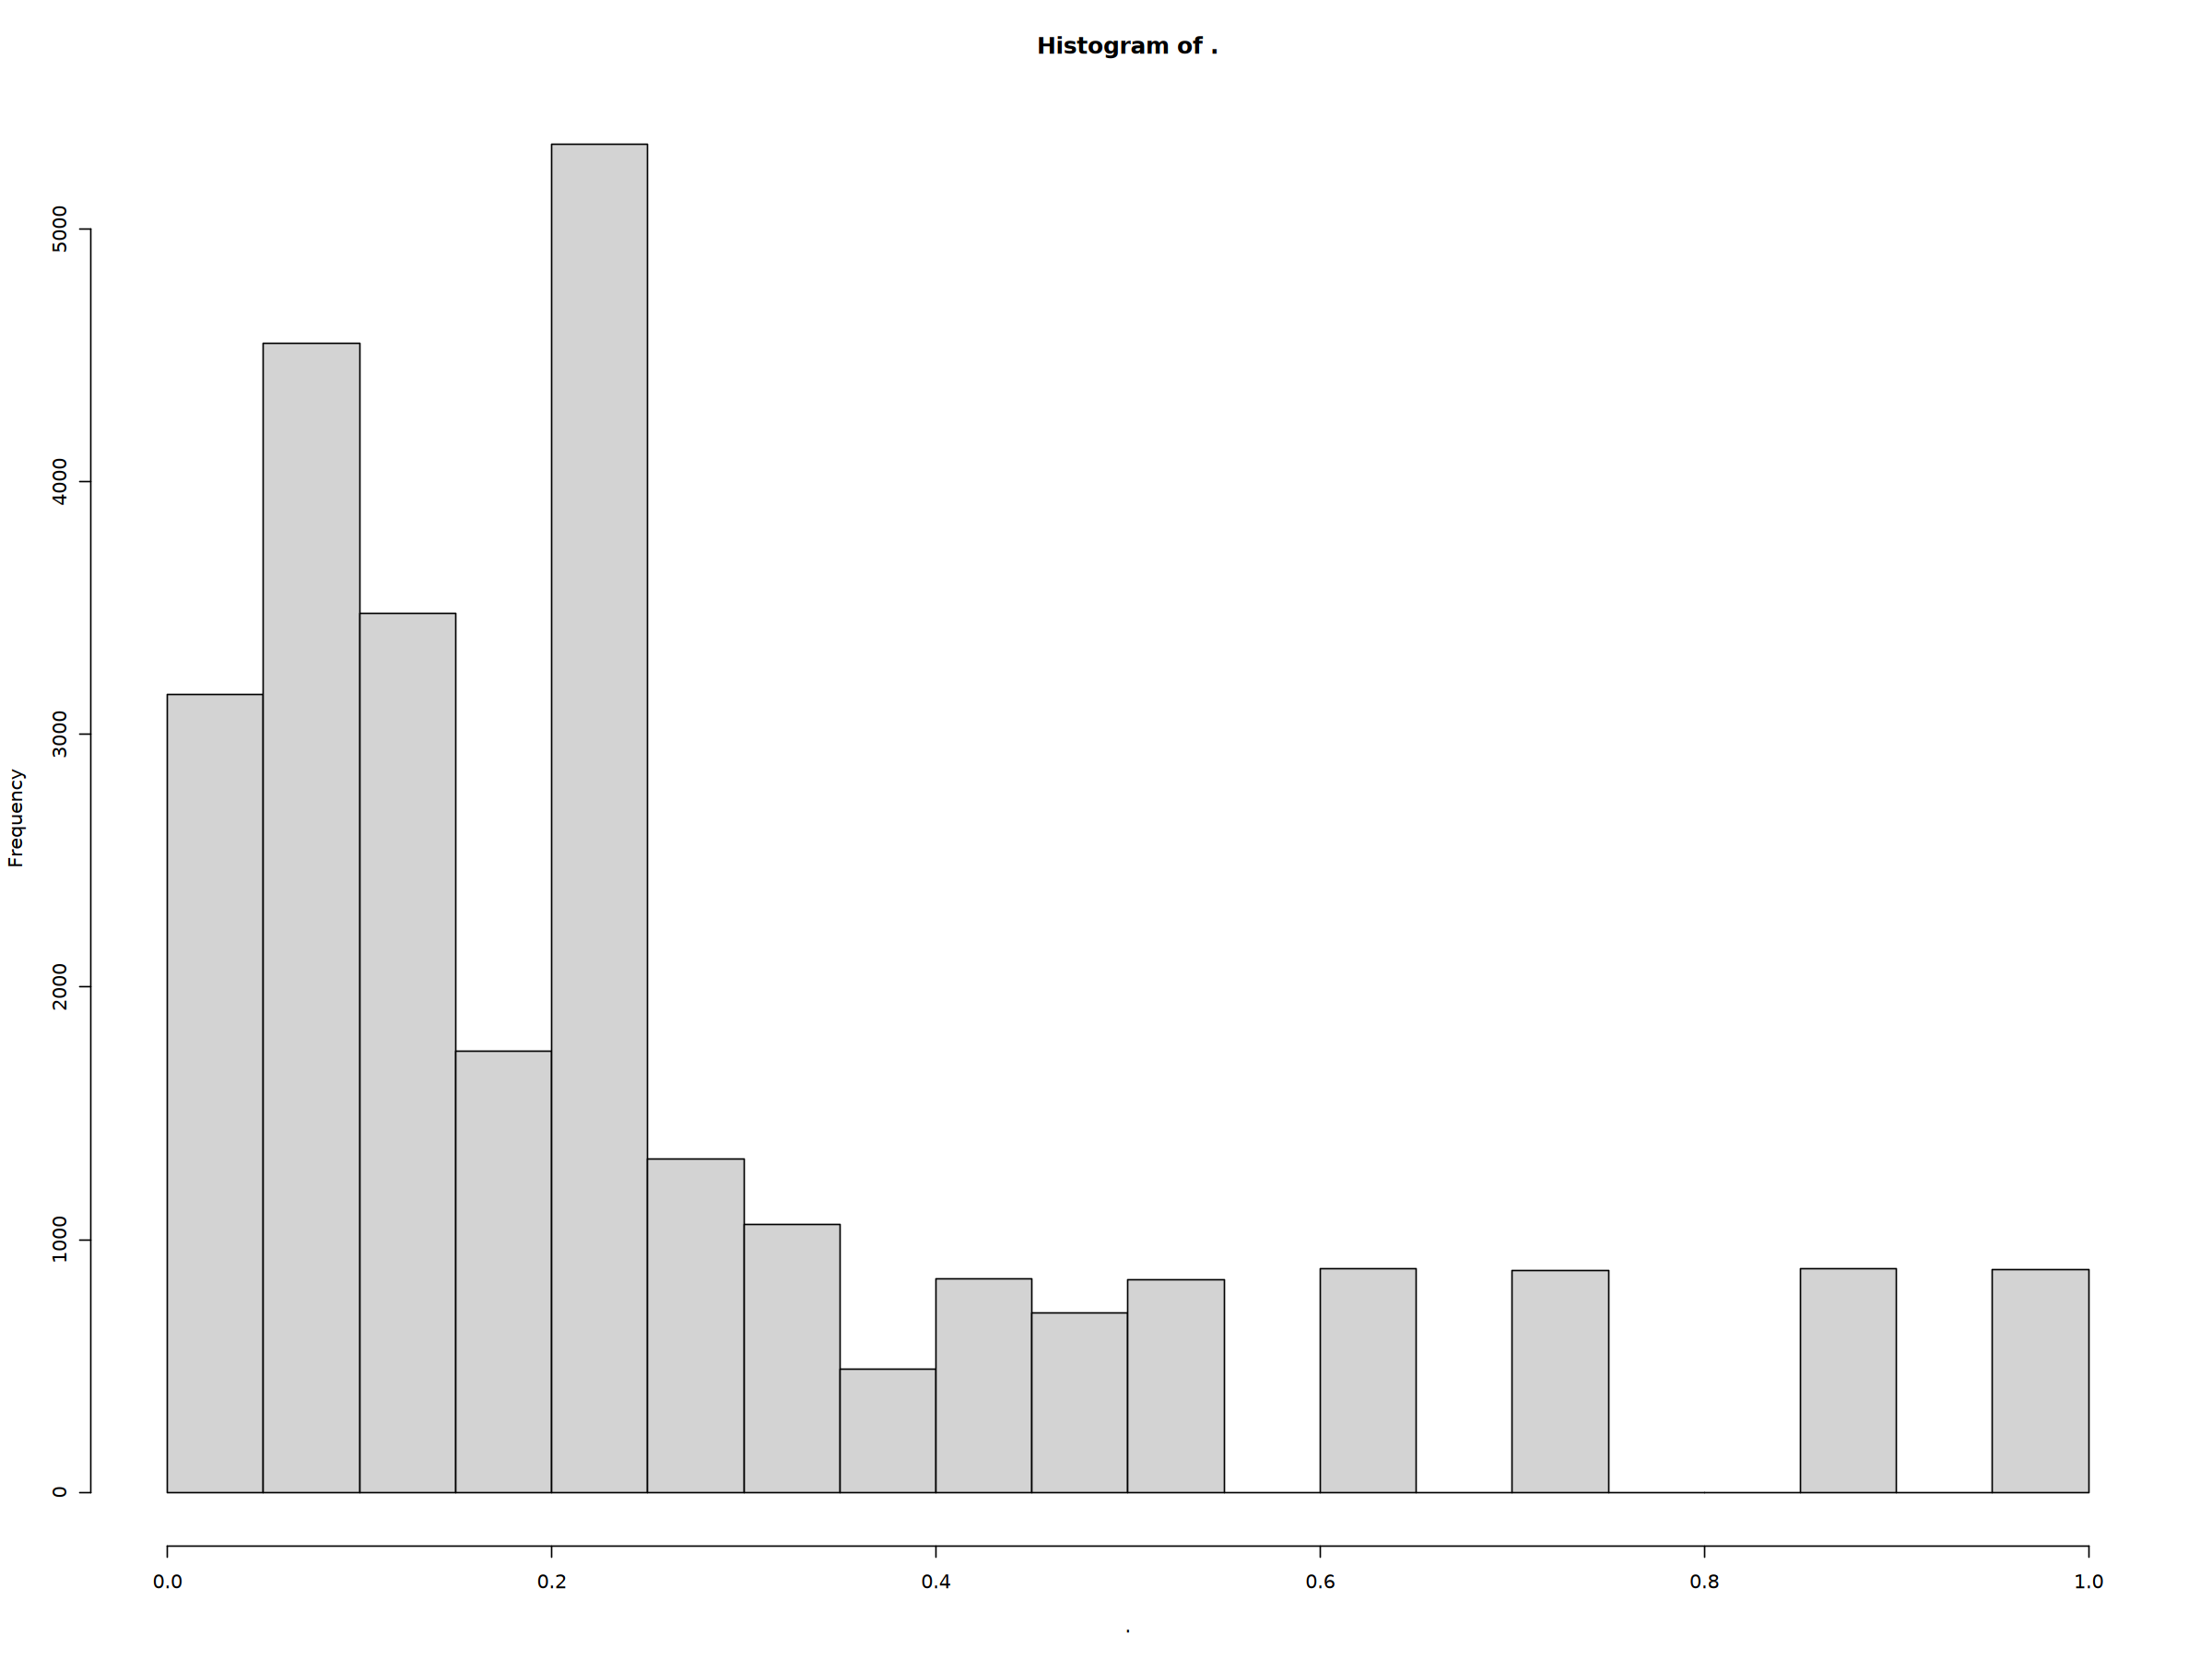

In [23]:
cd4na_diff$P_value %>% hist()


In [31]:
cd4na_diff %>% filter(P_value < 0.05 & str_detect(Gene, "IL21"))


GRanges object with 1 range and 15 metadata columns:
      seqnames              ranges strand |                   Tile
         <Rle>           <IRanges>  <Rle> |            <character>
  [1]     chr4 122617500-122617999      * | chr4:122617500-12261..
      CellPopulation  Foreground  Background   P_value Test_Statistic       FDR
         <character> <character> <character> <numeric>      <numeric> <numeric>
  [1]      cd4_naive      pre-RA     Healthy 0.0041014        8.23837 0.0705946
       Log2FC_C  MeanDiff Avg_Intensity_Case Pct0_Case Avg_Intensity_Control
      <numeric> <numeric>          <numeric> <numeric>             <numeric>
  [1]        NA   7.78541            7.75858         0                    NA
      Pct0_Control    tileType        Gene
         <numeric> <character> <character>
  [1]            1    Promoter        IL21
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

In [38]:
cd4na_diff_sig <- cd4na_diff %>%
    filter(FDR < 0.1 & P_value < 0.05) %>%
    arrange(P_value)
cd4na_diff_sig %>%
    as_tibble() %>%
    filter(is.na(P_value))


seqnames,start,end,width,strand,Tile,CellPopulation,Foreground,Background,P_value,Test_Statistic,FDR,Log2FC_C,MeanDiff,Avg_Intensity_Case,Pct0_Case,Avg_Intensity_Control,Pct0_Control,tileType,Gene
<fct>,<int>,<int>,<int>,<fct>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>


In [42]:
cd4na_diff_sig %>%
    as_tibble() %>%
    filter(str_detect(Gene, "PPP"))


seqnames,start,end,width,strand,Tile,CellPopulation,Foreground,Background,P_value,Test_Statistic,FDR,Log2FC_C,MeanDiff,Avg_Intensity_Case,Pct0_Case,Avg_Intensity_Control,Pct0_Control,tileType,Gene
<fct>,<int>,<int>,<int>,<fct>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
chr10,131956000,131956499,500,*,chr10:131956000-131956499,cd4_naive,pre-RA,Healthy,0.004101401,8.238367,0.07059460,NA,6.90200860,7.006577,0.0000000,NA,1.0,Promoter,PPP2R2D
chrX,49286500,49286999,500,*,chrX:49286500-49286999,cd4_naive,pre-RA,Healthy,0.004101401,8.238367,0.07059460,NA,7.50467806,7.176949,0.0000000,NA,1.0,Promoter,PPP1R3F
chr6,30067000,30067499,500,*,chr6:30067000-30067499,cd4_naive,pre-RA,Healthy,0.009366112,6.751648,0.07059460,-0.11571156,-0.11166041,16.006189,0.0000000,16.079099,0.0,Promoter,PPP1R11
chr20,59940000,59940499,500,*,chr20:59940000-59940499,cd4_naive,pre-RA,Healthy,0.014850938,5.934066,0.07059460,0.32618180,0.29845521,14.061487,0.0000000,13.720650,0.0,Promoter,"FAM217B, PPP1R3D"
chr19,45141000,45141499,500,*,chr19:45141000-45141499,cd4_naive,pre-RA,Healthy,0.019172485,5.485714,0.07059460,NA,6.09967524,7.295271,0.1428571,NA,1.0,Promoter,PPP1R37
chr9,125154000,125154499,500,*,chr9:125154000-125154499,cd4_naive,pre-RA,Healthy,0.022773310,5.185714,0.07059460,NA,-5.37774071,NA,1.0000000,6.541415,0.2,Promoter,PPP6C
chrX,347000,347499,500,*,chrX:347000-347499,cd4_naive,pre-RA,Healthy,0.022773310,5.185714,0.07059460,0.74353273,5.85226290,7.176949,0.0000000,6.433416,0.8,Promoter,PPP2R3B
chrX,361500,361999,500,*,chrX:361500-361999,cd4_naive,pre-RA,Healthy,0.022773310,5.185714,0.07059460,-0.89651852,6.00772714,7.647061,0.0000000,8.543579,0.8,Promoter,PPP2R3B
chr17,81833000,81833499,500,*,chr17:81833000-81833499,cd4_naive,pre-RA,Healthy,0.022990394,5.169231,0.07059460,0.23187645,0.22212064,14.937023,0.0000000,14.740606,0.0,Promoter,"MCRIP1, PPP1R27"


In [41]:
cd4na_diff_sig %>%
    as_tibble() %>%
    write_csv(file.path(output_path, paste0(proj_name, "cd4na_atac_sig_daps.csv")))


### TSS start site analysis

In [ ]:
cd4na_diff_tss <- getAltTSS(cd4na_diff, returnAllTSS = TRUE, effectSize = "Log2FC_C")


In [ ]:
cd4na_diff_tss_tb <- cd4na_diff_tss %>%
    as_tibble() %>%
    distinct(Tile, .keep_all = TRUE) %>%
    filter(!is.na(Gene) & !is.na(FDR) & !is.na(Log2FC_C)) %>%
    distinct(name, .keep_all = TRUE) %>%
    mutate(log10fdr_dir = -log10(FDR) * sign(Log2FC_C))
cd4na_diff_tss_tb %>% head()


In [ ]:
marker_genes <- c("GATA3", "RORC", "FOXP3", "TBX21", "IKZF2", "STAT3", "RORA", "IFNG-AS1", "CCL5")

cd4na_diff_tss_tb %>% filter(FDR < 0.2 & str_detect(name, "IL\\d|CD\\d|IFN|TNF"))


In [ ]:
cd4na_diff_tss_tb %>% colnames()
cd4na_diff_tss_tb$Test_Statistic %>% hist()


In [ ]:
p1 <- EnhancedVolcano::EnhancedVolcano(cd4na_diff_tss_tb,
     title = NULL,
     subtitle = NULL,
     lab = cd4na_diff_tss_tb %>% pull(name),
     x = "Log2FC_C",
     FCcutoff = 0.1,
     pCutoff = 0.2,
     y = "FDR", labSize = 3.0
) +
     coord_cartesian(xlim = c(-2.5, 2.5), ylim = c(0, 0.8)) +
     theme(
          legend.position = "bottom", legend.title = element_blank(),
          text = element_text(size = 12)
     )
p1
ggsave(file.path(fig_path, paste0(proj_name, "_cd4na_DA_TSS_valcano_plot.pdf")),
     width = 16, height = 12
)


In [ ]:
cd4na_tss_gsea <- RunGSEA(
    ranked_list = cd4na_diff_tss_tb, gmx = gmx,
    gene_col = "name", rank_col = "Log2FC_C",
    collapsePathways = TRUE
)
cd4na_tss_gsea


In [ ]:
# isolate the results for promotor
cd4na_diff_prom <- cd4na_diff[(!is.na(elementMetadata(cd4na_diff)[, "FDR"])) &
    elementMetadata(cd4na_diff)[, "tileType"] == "Promoter"]
# cd4na_diff_prom$fdr_prom = p.adjust(cd4na_diff_prom$P_value, method='BH')
# cd4na_diff_prom$FDR <- p.adjust(cd4na_diff_prom$P_value, method='BH')


In [ ]:
cd4na_diff_prom %>%
    filter(FDR < 0.2 & abs(Log2FC_C) > 0.5) %>%
    as_tibble() %>%
    group_by(Gene) %>%
    tally() %>%
    arrange(desc(n))


In [ ]:
cd4na_diff_prom %>%
    filter(FDR < 0.2) %>%
    as_tibble() %>%
    arrange(desc(Log2FC_C)) %>%
    head(30)


In [ ]:
cd4na_diff_prom %>%
    filter(str_detect(Gene, "CD\\d|IL\\d|IL17|TGFBR")) %>%
    as_tibble() %>%
    arrange(FDR) %>%
    distinct(Gene) %>%
    pull(Gene)


In [ ]:
marker_genes <- c(
    "IFNG-AS1", "IL17A", "IL17F", "IL22", "IFN", "IL4", "CSF", "IL\\d",
    "IL12A", "IL10", "IL5", "IL13", "RORC", "STAT3", "RORA", "FOXP3", "TBX21"
)
cd4na_diff_prom[str_detect(elementMetadata(cd4na_diff_prom)[, "Gene"], paste(marker_genes, collapse = "|"))] %>%
    as_tibble() %>%
    filter(FDR < 0.2)


In [ ]:
gene_name <- "IL21"
sig_gene_diff <- cd4na_diff_prom %>%
    filter(FDR < 0.2 & str_detect(Gene, gene_name)) %>%
    as_tibble() %>%
    arrange(desc(Log2FC_C))
plot_gene_ranges <- paste0(
    unique(sig_gene_diff$seqnames), ":", min(sig_gene_diff$start) - 1000,
    "-", max(sig_gene_diff$end) + 1000
)
plot_gene_ranges


In [ ]:
sig_gene_diff


In [ ]:
# plot DAP promoters region
# get the gene names and gene ranges
gene_name <- "TGFBR1"
gene_ranges <- txList[[gene_name]] %>%
    as_tibble() %>%
    mutate(gene_range = paste0(seqnames, ":", start - 2000, "-", end + 2000))
# marker_genes='EIF1'
# gene_ranges <- cd4na_diff_prom[str_detect(elementMetadata(cd4na_diff_prom)[,'Gene'],
#                                           paste(marker_genes,collapse = '|'))] %>%
#     as_tibble() %>% filter(FDR<0.2)
plot_gene_ranges <- gene_ranges$gene_range[1]


In [ ]:
####################################################
# 5. (Optional) Plot a specific region's coverage.
#    Here we plot coverage at a specific region and
#    gene by infection stage.
####################################################
countSE <- MOCHA::extractRegion(
  SampleTileObj = SampleTileMatricesAnnotated,
  cellPopulations = "cd4_naive",
  region = plot_gene_ranges,
  groupColumn = "cohort",
  numCores = 62,
  sampleSpecific = FALSE
)


In [ ]:
countSE


In [ ]:
pdf(file.path(fig_path, paste0(
    "cd4_naive_atac_annotate_",
    gene_name, "_gene_regions.pdf"
)), width = 16, height = 12)
MOCHA::plotRegion(countSE = countSE)
dev.off()


In [ ]:
countSE


In [ ]:
countSE <- MOCHA::addAccessibilityShift(CountSE = countSE, foreground = "cd4_naive.pre-RA", background = "cd4_naive.Healthy")


In [ ]:
pdf(file.path(fig_path, paste0(
    "cd4_naive_atac_annotate_",
    gene_name, "_gene_regions.pdf"
)), width = 16, height = 12)
MOCHA::plotRegion(countSE = countSE)
dev.off()


In [ ]:
MOCHA::plotRegion(countSE = countSE)


### take a look of the genes promoter and expression difference

In [ ]:
# get deg list of the cd4 naive
cd4na_pseudo_degs <- ra_tea_cd4_pseudo_degs %>%
    filter(cell_type == "cd4_naive") %>%
    mutate("log10FDR" = if_else(logFC > 0, -log10(FDR), log10(FDR)))
cd4na_pseudo_degs %>% head()


In [ ]:
# get dap promoter list of the cd4 naive
cd4na_dap_prom <- cd4na_diff_prom %>%
    as_tibble() %>%
    mutate("log10FDR" = if_else(Log2FC_C > 0, -log10(FDR), log10(FDR))) %>%
    dplyr::rename("gene" = "Gene")
cd4na_dap_prom %>%
    filter(FDR < 0.2) %>%
    head()
cd4na_dap_prom %>%
    filter(str_detect(gene, ",")) %>%
    nrow()
cd4na_diff_prom %>%
    as_tibble() %>%
    nrow()


In [ ]:
# join two list
cd4na_degs_dap_prom <- cd4na_pseudo_degs %>%
    full_join(cd4na_dap_prom, by = "gene", suffix = c("_rna", "_atac")) %>%
    mutate(log10FDR_rna = replace_na(log10FDR_rna, 0), log10FDR_atac = replace_na(log10FDR_atac, 0)) %>%
    filter(!str_detect(gene, ","))
cd4na_degs_dap_prom %>% head()


In [ ]:
cd4na_degs_dap_prom %>% filter(str_detect(gene, "TGFBR|CARD11|IL\\d") & FDR_atac < 0.3)


In [ ]:
fig_path


In [ ]:
#
cd4na_degs_dap_prom %>% ggplot(aes(x = log10FDR_rna, y = log10FDR_atac, label = gene)) +
    geom_point() +
    geom_hline(yintercept = -log10(0.2), linetype = "dashed", color = "red") +
    geom_hline(yintercept = log10(0.2), linetype = "dashed", color = "red") +
    geom_vline(xintercept = -log10(0.2), linetype = "dashed", color = "red") +
    geom_vline(xintercept = log10(0.2), linetype = "dashed", color = "red")
ggsave(file.path(fig_path, paste0(proj_name, "_gene_exp_promotor_DA_promoters.pdf")), width = 6, height = 6)


In [ ]:
poised_gene <- cd4na_degs_dap_prom %>%
    filter(FDR_atac < 0.2 & FDR_rna > 0.05 & Log2FC_C > 0) %>%
    pull(gene) %>%
    str_split(", ") %>%
    unlist() %>%
    unique()

# pathway enrichment for cd4na
enrich_cd4na_posied <- enrichr(poised_gene, c("KEGG_2021_Human", "MSigDB_Hallmark_2020"))


In [ ]:
poised_gene


In [ ]:
enrich_cd4na_posied[["MSigDB_Hallmark_2020"]] %>%
    filter(Adjusted.P.value < 0.05) %>%
    dplyr::select(-c(Old.P.value, Old.Adjusted.P.value))


In [ ]:
enrich_cd4na_posied[["KEGG_2021_Human"]] %>%
    filter(Adjusted.P.value < 0.05) %>%
    dplyr::select(-c(Old.P.value, Old.Adjusted.P.value))


In [ ]:
# get dap promoter list of the cd4 naive
cd4na_dap_prom <- cd4na_diff_prom %>%
    as_tibble() %>%
    mutate("log10FDR" = if_else(Log2FC_C > 0, -log10(FDR), log10(FDR))) %>%
    dplyr::rename("gene" = "Gene")
cd4na_dap_prom %>%
    filter(FDR < 0.2) %>%
    head()
cd4na_dap_prom %>%
    filter(str_detect(gene, ",")) %>%
    nrow()
cd4na_diff_prom %>%
    as_tibble() %>%
    nrow()


### run DAP analysis for cd4 memory

In [ ]:
SampleTileMatricesAnnotated


In [ ]:
# replace NA as 0
cd4n_counts <- assay(SampleTileMatricesAnnotated, "cd4_memory") %>% as.data.frame()
cd4n_counts[is.na(cd4n_counts)] <- 0
assay(SampleTileMatricesAnnotated, "cd4_memory") <- cd4n_counts %>% as.matrix()


In [ ]:
assay(SampleTileMatricesAnnotated, "cd4_memory") %>% anyNA()


In [ ]:
####################################################
# 5. Get differential accessibility for specific
#    cell populations. Here we are comparing MAIT
#    cells between samples where our groupColumn
#    "COVID_status" is Positive (our foreground)
#    to Negative samples (our background).
####################################################
threshold <- 0.2
groupColumn <- "cohort"
join <- "union"
numCores <- 58
outputGRanges <- TRUE
cd4_tcm_diff <- MOCHA::getDifferentialAccessibleTiles(
    SampleTileObj = SampleTileMatricesAnnotated,
    cellPopulation = "cd4_memory",
    groupColumn = groupColumn,
    foreground = "pre-RA",
    background = "Healthy",
    fdrToDisplay = 0.2,
    signalThreshold = 13,
    minZeroDiff = 0.5,
    outputGRanges = TRUE,
    numCores = numCores
)


In [ ]:
SampleTileMatricesAnnotated[str_detect(rowData(SampleTileMatricesAnnotated)$Gene, "IL21") %>% replace_na(FALSE), ]


In [ ]:
# str_detect(rowData(SampleTileMatricesAnnotated)$Gene, 'IL21|ZEB2|BCL6|IL\\d')%>%replace_na(FALSE)


In [ ]:
####################################################
# test DAPs for IL21
####################################################
threshold <- 0.2
groupColumn <- "cohort"
join <- "union"
numCores <- 58
outputGRanges <- TRUE
cd4_tcm_diff <- MOCHA::getDifferentialAccessibleTiles(
    SampleTileObj = SampleTileMatricesAnnotated[str_detect(rowData(SampleTileMatricesAnnotated)$Gene, "IL21") %>% replace_na(FALSE), ],
    cellPopulation = "cd4_memory",
    groupColumn = groupColumn,
    foreground = "pre-RA",
    background = "Healthy",
    fdrToDisplay = 0.2,
    signalThreshold = 0,
    minZeroDiff = 0.5,
    outputGRanges = TRUE,
    numCores = numCores
)


In [ ]:
cd4_tcm_diff <- annotateTiles(cd4_tcm_diff, TxDb = TxDb, Org = Org)


In [ ]:
cd4_tcm_diff %>%
    filter(P_value < 0.05) %>%
    as_tibble()


In [ ]:
####################################################
# 5. Get differential accessibility for specific
#    cell populations. Here we are comparing MAIT
#    cells between samples where our groupColumn
#    "COVID_status" is Positive (our foreground)
#    to Negative samples (our background).
####################################################
threshold <- 0.2
groupColumn <- "cohort"
join <- "union"
numCores <- 30
outputGRanges <- TRUE
cd4_treg_diff <- MOCHA::getDifferentialAccessibleTiles(
    SampleTileObj = SampleTileMatricesAnnotated,
    cellPopulation = "treg",
    groupColumn = groupColumn,
    foreground = "pre-RA",
    background = "Healthy",
    fdrToDisplay = 0.2,
    signalThreshold = 15,
    minZeroDiff = 0.5,
    outputGRanges = TRUE,
    numCores = numCores
)


In [ ]:
cd4_tem_diff <- annotateTiles(cd4_tem_diff,
    TxDb = TxDb,
    Org = Org
)


In [ ]:
# save the DAP results
cd4_tem_diff %>% saveRDS(file.path(output_path, paste0(proj_name, "cd4_tem_preRAvshealthy_DAPs.rds")))


In [ ]:
cd4_tem_prom_diff[cd4_tem_prom_diff$FDR < 0.2]$Gene %>%
    str_subset("ROR|TBX|IKZF|FOXP|GATA|IL\\d")


In [ ]:
# load the DAP results
cd4_tem_diff <- readRDS(file.path(output_path, "PreRA_teaseq_cd4_t_cd4_tem_preRAvshealthy_DAPs.rds"))


In [ ]:
cd4_tem_diff %>%
    filter(FDR < 0.2 & P_value < 0.05 & str_detect(Gene, "IL\\d")) %>%
    as_tibble()


### pathway enrichment of the promoter

In [ ]:
# isolate the results for promotor
cd4na_prom <- cd4na_diff[(!is.na(elementMetadata(cd4na_diff)[, "FDR"])) &
    elementMetadata(cd4na_diff)[, "tileType"] == "Promoter"]
# cd4na_diff_prom$fdr_prom = p.adjust(cd4na_diff_prom$P_value, method='BH')
# cd4na_prom %>% as_tibble() %>% filter(str_detect(Gene, ', '))
cd4na_diff_prom <- cd4na_prom %>% filter(FDR < 0.2 & Log2FC_C > 0.1)
cd4na_diff_prom_genes <- cd4na_diff_prom %>%
    as_tibble() %>%
    pull(Gene) %>%
    str_split(", ") %>%
    unlist() %>%
    unique()


In [ ]:
cd4na_prom %>%
    filter(FDR < 0.2) %>%
    as_tibble() %>%
    pull(Log2FC_C) %>%
    hist()


In [ ]:
cd4na_diff_prom_genes %>% length()
cd4na_diff_prom_genes


In [ ]:
# pathway enrichment for cd4na
enrich_cd4_na <- enrichr(cd4na_diff_prom_genes, c("KEGG_2021_Human", "MSigDB_Hallmark_2020"))
enrich_cd4_na[["KEGG_2021_Human"]] %>% filter(Adjusted.P.value < 0.05)


In [ ]:
enrich_cd4_na[["MSigDB_Hallmark_2020"]] %>% filter(Adjusted.P.value < 0.05)


In [ ]:
plotEnrich(enrich_cd4_na[["MSigDB_Hallmark_2020"]],
       title = "CD4 Naive DA-promoters",
       showTerms = 7, numChar = 40, y = "Count", orderBy = "Adjusted.P.value"
)
ggsave(file.path(fig_path, paste0(proj_name, "_CD4 Naive DA-promoters_hallmark_pathay.pdf")),
       width = 8, height = 6
)


In [ ]:
cd4na_prom %>%
    filter(!is.na(Log2FC_C) & Pct0_Control > 0.8 & Pct0_Case == 0) %>%
    as_tibble()


In [ ]:
# create rank list based on lowest to higest gene fold-change
DAPgsea <- function(logfc_list) {
    rnkDF <- logfc_list %>%
        filter(.data[[ct.col]] == ct) %>%
        arrange(logFC)
    rnk <- as.numeric(rnkDF$logFC)
    names(rnk) <- rnkDF$gene
    message(paste("run GSEA in", length(rnk), "genes"))
    # run GSEA by parallelization
    fgseaRes <- fgsea::fgsea(
        pathways = gmx,
        stats = rnk,
        minSize = 10,
        maxSize = 500,
        BPPARAM = param
    )

    # filter on pathways <0.05 adjusted p-value
    fgseaRes2 <- fgseaRes %>%
        as.data.frame() %>%
        select(pathway, pval, padj, NES, leadingEdge) %>%
        arrange(desc(NES)) %>%
        mutate(celltype = ct)
}


In [ ]:
# isolate the results for promotor
cd4_tem_prom_diff <- cd4_tem_diff[(!is.na(elementMetadata(cd4_tem_diff)[, "FDR"])) &
    elementMetadata(cd4_tem_diff)[, "tileType"] == "Promoter" &
    elementMetadata(cd4_tem_diff)[, "FDR"] < 0.2] # %>%filter(Log2FC_C>0.1)
cd4tem_diff_prom_genes <- cd4_tem_prom_diff %>%
    as_tibble() %>%
    pull(Gene) %>%
    str_split(", ") %>%
    unlist() %>%
    unique()
cd4tem_diff_prom_genes %>% length()


In [ ]:
# pathway enrichment for cd4tem
enrich_cd4_tem <- enrichr(cd4tem_diff_prom_genes, c("KEGG_2021_Human", "MSigDB_Hallmark_2020"))
enrich_cd4_tem[["MSigDB_Hallmark_2020"]] %>% filter(Adjusted.P.value < 0.05)


In [ ]:
plotEnrich(enrich_cd4_tem[["MSigDB_Hallmark_2020"]],
       title = "CD4 TEM DA-promoters",
       showTerms = 11, numChar = 40, y = "Count", orderBy = "Adjusted.P.value"
)
ggsave(file.path(fig_path, paste0(proj_name, "_CD4 TEM DA-promoters_hallmark_pathay.pdf")),
       width = 8, height = 6
)


## motif analysis

### motif enrichment of the DAPs

In [ ]:
# load the DAP results
cd4na_diff <- readRDS(file.path(output_path, paste0(proj_name, "cd4_naive_preRAvshealthy_DAPs.rds")))


In [ ]:
cd4na_daps_up <- cd4na_diff %>% filter(FDR < 0.2 & Log2FC_C > 0)


In [ ]:
# cd4na_daps


In [ ]:
cd4na_daps_up_motif <- MOCHA::MotifEnrichment(
    Group1 = cd4na_daps_up, cd4na_diff %>% filter(FDR > 0.2),
    motifPosList = metadata(SampleTileMatricesAnnotated)$Motifs
)


In [ ]:
cd4na_daps_up_motif %>% arrange(adjp_val)


### chromvar deviation analysis

In [ ]:
## runChromVar is a wrapper for chromVAR from scMACS
## Obj could be a ragged experiment or a sumarized experiment
## motifGRangesList is a list of all motif positions in a GRangesList format
## genome is the reference genome we use

runChromvar <- function(SampleTileMatrices, cell_type, genome = BSgenome.Hsapiens.UCSC.hg38) {
    require(chromVAR)
    require(MOCHA)
    # extract the mocha sampe tile matrix for the selected cell type
    message("extracting mocha sample tile matrix...")
    assayList <- getCellPopMatrix(SampleTileMatrices, cell_type)
    ATAC.se <- SummarizedExperiment(
        assays = list("counts" = assayList),
        colData = colData(SampleTileMatrices),
        rowRanges = rowRanges(SampleTileMatrices) %>% plyranges::filter(!!sym(cell_type) == TRUE),
        metadata = SampleTileMatrices@metadata
    )

    message("add GC bias...")
    ATAC.se <- chromVAR::addGCBias(ATAC.se, genome = genome)
    if (any(is.na(rowData(ATAC.se)$bias))) {
        warning("There is NA in chromvar matched GC bias. \n The peaks that contain NA will be removed.")
        ATAC.se <- ATAC.se[!is.na(rowData(ATAC.se)$bias), ]
    }
    message("run chromvar...")
    CisbpAnno <- chromVAR::getAnnotations(metadata(ATAC.se)$Motifs, rowRanges = rowRanges(ATAC.se))
    dev <- chromVAR::computeDeviations(
        object = ATAC.se,
        annotations = CisbpAnno
    )
    return(dev)
}


In [ ]:
metadata(SampleTileMatricesAnnotated)$Motifs


In [ ]:
cd4na_dev <- runChromvar(SampleTileMatricesAnnotated,
    cell_type = "cd4_naive",
    genome = BSgenome.Hsapiens.UCSC.hg38
)


In [ ]:
cd4na_dev
# save chromvar motif deviation in cd4 naive
cd4na_dev %>% saveRDS(file.path(output_path, paste0(proj_name, "_cd4naive_DAP_chromvar_deviation.rds")))


In [ ]:
file.path(output_path, paste0(proj_name, "_cd4naive_DAP_chromvar_deviation.rds"))


In [ ]:
# save chromvar motif deviation in cd4 naive
cd4na_dev <- readRDS(file.path(output_path, paste0(proj_name, "_cd4naive_DAP_chromvar_deviation.rds")))
cd4na_dev


In [ ]:
tsne_results <- deviationsTsne(cd4na_dev,
    threshold = 1.5, perplexity = 10,
    shiny = FALSE
)


In [ ]:
colData(cd4na_dev) %>% colnames()


In [ ]:
# extract the deviation score
cd4na_dev_score <- deviations(cd4na_dev) %>%
    as_tibble(rownames = "motif") %>%
    pivot_longer(cols = -motif, names_to = "Sample", values_to = "deviation_score") %>%
    left_join(as_tibble(colData(cd4na_dev)), by = "Sample") %>%
    mutate(cohort = factor(cohort, levels = c("Healthy", "pre-RA")))
cd4na_dev_score %>% head()


In [ ]:
cd4na_dev_score %>% ggplot(aes(x = deviation_score, fill = cohort)) +
    geom_histogram()


In [ ]:
# run wilcox test for the motif scores
cd4na_dev_test <- cd4na_dev_score %>%
    filter(!is.na(deviation_score)) %>%
    mutate(cohort = factor(cohort, levels = c("pre-RA", "Healthy"))) %>%
    group_by(motif) %>%
    rstatix::t_test(data = ., deviation_score ~ cohort) %>%
    rstatix::adjust_pvalue(method = "BH") %>%
    rstatix::add_significance("p.adj") %>%
    mutate(log10p_dir = -log10(p) * sign(statistic))


In [ ]:
motifs <- c("GATA3", "RORC", "FOXP3", "TBX21", "IKZF2", "STAT3", "STAT4", "STAT6")

cd4na_dev_test %>% filter((motif %in% motifs | str_detect(motif, "IL\\d|CD\\d")) & p < 0.05)


In [ ]:
cd4na_dev_sig <- cd4na_dev_test %>%
    arrange(p.adj) %>%
    filter(p.adj < 0.3)
cd4na_dev_sig


In [ ]:
# run gsea by a customized ranked list

RunGSEA <- function(ranked_list, gmx, gene_col = "gene", rank_col = "logFC", collapsePathways = FALSE, ncores = NULL) {
    # setup parallelization parameters
    if (is.null(ncores)) {
        ncores <- parallel::detectCores() - 3
    } else {
        (ncores <- ncores)
    }
    param <- BiocParallel::MulticoreParam(workers = ncores, progressbar = TRUE)

    # create rank list based on lowest to higest gene fold-change
    rnkDF <- ranked_list %>% arrange(.data[[rank_col]])
    rnk <- as.numeric(rnkDF %>% pull(.data[[rank_col]]))
    names(rnk) <- rnkDF %>% pull(.data[[gene_col]])

    message(paste("run GSEA in", length(rnk), "genes"))
    # run GSEA by parallelization
    fgseaRes <- fgsea::fgsea(
        pathways = gmx,
        stats = rnk,
        minSize = 10,
        maxSize = 500,
        BPPARAM = param
    )

    # filter on pathways <0.05 adjusted p-value
    fgseaRes2 <- fgseaRes %>%
        as.data.frame() %>%
        dplyr::select(pathway, pval, padj, NES, leadingEdge) %>%
        arrange(desc(NES)) %>%
        dplyr::filter(padj < 0.05)
    # if only keep the main pathway
    if (collapsePathways) {
        collapsedPathways <- fgsea::collapsePathways(
            fgseaRes[order(pval)][padj < 0.05],
            gmx, rnk
        )
        mainPathways <- fgseaRes[pathway %in% collapsedPathways$mainPathways][
            order(-NES), pathway
        ]
        fgseaRes2 <- fgseaRes2 %>% dplyr::filter(pathway %in% mainPathways)
    }

    fgseaRes2$leadingEdge <- vapply(fgseaRes2$leadingEdge,
        paste,
        collapse = ", ",
        character(1L)
    )
    return(fgseaRes2)
}


In [ ]:
cd4na_dev_test %>% filter(str_detect(motif, "STAT"))


In [ ]:
cd4na_dev_gsea <- RunGSEA(
    ranked_list = cd4na_dev_test, gmx = gmx,
    gene_col = "motif", rank_col = "log10p_dir",
    collapsePathways = TRUE
)
cd4na_dev_gsea


In [ ]:
cd4na_dev_score %>%
    filter(!is.na(deviation_score) & motif %in% cd4na_dev_sig$motif) %>%
    ggplot(aes(x = cohort, y = deviation_score)) +
    geom_violin(aes(fill = cohort)) +
    geom_jitter() +
    facet_wrap(vars(motif), scales = "free_y")
ggsave(file.path(fig_path, paste0(proj_name, "_cd4_naive_chromvar_motif_sig.pdf")),
    width = 12, height = 6
)


In [ ]:
cd4na_dev_score %>%
    filter(!is.na(deviation_score) & motif %in% c("STAT3", "RORA", "RORC", "FOXP3", "TBX21")) %>%
    ggplot(aes(x = cohort, y = deviation_score)) +
    geom_violin(aes(fill = cohort)) +
    geom_jitter() +
    facet_wrap(vars(motif), scales = "free_y")
ggsave(file.path(fig_path, paste0(proj_name, "_cd4_naive_chromvar_motif_selects.pdf")),
    width = 8, height = 6
)


In [ ]:
# plot motif scores on umap space
motifs <- cd4na_dev_sig$motif
markerMotifs <- getFeatures(cd4t_atac, select = paste(motifs, collapse = "|"), useMatrix = "MotifMatrix")
markerMotifs <- grep("z:", markerMotifs, value = TRUE)
markerMotifs
p1 <- plotEmbedding(
    ArchRProj = cd4t_atac,
    colorBy = "MotifMatrix",
    name = sort(markerMotifs),
    embedding = "UMAP",
    imputeWeights = getImputeWeights(cd4t_atac)
)
p2 <- plotEmbedding(
    ArchRProj = cd4t_atac,
    colorBy = "GeneExpressionMatrix",
    name = "NR3C1",
    embedding = "UMAP",
    imputeWeights = getImputeWeights(cd4t_atac)
)
plotPDF(p1, p2,
    name = paste0(proj_name, "_atac_umap_cd4na_chrovar_motif_sig.pdf"), ArchRProj = cd4t_atac,
    addDOC = FALSE, width = 6, height = 6
)


In [ ]:
# Chromvar for cd4 tem
cd4tem_dev <- runChromvar(SampleTileMatricesAnnotated,
    cell_type = "cd4_tem",
    genome = BSgenome.Hsapiens.UCSC.hg38
)


In [ ]:
# save chromvar motif deviation in cd4 naive
cd4tem_dev %>% saveRDS(file.path(output_path, paste0(proj_name, "_cd4tem_chromvar_deviation.rds")))


In [ ]:
# extract the deviation score
cd4tem_dev_score <- deviations(cd4tem_dev) %>%
    as_tibble(rownames = "motif") %>%
    pivot_longer(cols = -motif, names_to = "Sample", values_to = "deviation_score") %>%
    left_join(as_tibble(colData(cd4tem_dev)), by = "Sample") %>%
    mutate(cohort = factor(cohort, levels = c("Healthy", "pre-RA")))
cd4tem_dev_score %>% head()


In [ ]:
# run wilcox test for the motif scores
cd4tem_dev_score_test <- cd4tem_dev_score %>%
    filter(!is.na(deviation_score)) %>%
    group_by(motif) %>%
    rstatix::t_test(data = ., deviation_score ~ cohort) %>%
    rstatix::adjust_pvalue(method = "BH") %>%
    rstatix::add_significance("p.adj")


In [ ]:
# run pathway ananlysis on the deviation socres


In [ ]:
cd4tem_dev_sig <- cd4tem_dev_score_test %>%
    arrange(p.adj) %>%
    filter(p.adj < 0.2)
cd4tem_dev_sig
cd4tem_dev_sig %>% filter(str_detect(motif, "STAT|ROR|FOXP"))


In [ ]:
cd4tem_dev_score %>%
    filter(!is.na(deviation_score) & motif %in% cd4tem_dev_sig$motif) %>%
    ggplot(aes(x = cohort, y = deviation_score)) +
    geom_violin(aes(fill = cohort)) +
    ggforce::geom_sina() +
    facet_wrap(vars(motif), scales = "free_y")
ggsave(file.path(fig_path, paste0(proj_name, "_cd4_tem_chromvar_motif_sig.pdf")),
    width = 12, height = 8
)


In [ ]:
# plot a heatmap for all the differential motif


In [ ]:
# Chromvar for cd4 TCM
cd4tcm_dev <- runChromvar(SampleTileMatricesAnnotated,
    cell_type = "cd4_tcm",
    genome = BSgenome.Hsapiens.UCSC.hg38
)


In [ ]:
# save chromvar motif deviation in cd4 naive
cd4tcm_dev %>% saveRDS(file.path(output_path, paste0(proj_name, "_cd4tcm_chromvar_deviation.rds")))


In [ ]:
# extract the deviation score
cd4tcm_dev_score <- deviations(cd4tcm_dev) %>%
    as_tibble(rownames = "motif") %>%
    pivot_longer(cols = -motif, names_to = "Sample", values_to = "deviation_score") %>%
    left_join(as_tibble(colData(cd4tcm_dev)), by = "Sample") %>%
    mutate(cohort = factor(cohort, levels = c("Healthy", "pre-RA")))
cd4tcm_dev_score %>% head()


In [ ]:
# run wilcox test for the motif scores
cd4tcm_dev_score_test <- cd4tcm_dev_score %>%
    filter(!is.na(deviation_score)) %>%
    group_by(motif) %>%
    rstatix::t_test(data = ., deviation_score ~ cohort) %>%
    rstatix::adjust_pvalue(method = "BH") %>%
    rstatix::add_significance("p.adj")


In [ ]:
# cd4tcm_dev_score_test


In [ ]:
cd4tcm_dev_sig <- cd4tcm_dev_score_test %>%
    arrange(p.adj) %>%
    filter(p.adj < 0.05)
cd4tcm_dev_sig


In [ ]:
cd4tcm_dev_sig %>% filter(str_detect(motif, "STAT"))


In [ ]:
# plot motif scores on umap space
motifs <- cd4tcm_dev_score %>%
    pull(motif) %>%
    str_subset("STAT") %>%
    unique()
markerMotifs <- getFeatures(cd4t_atac, select = paste(motifs, collapse = "|"), useMatrix = "MotifMatrix")
markerMotifs <- grep("z:", markerMotifs, value = TRUE)
markerMotifs
p <- plotEmbedding(
    ArchRProj = cd4t_atac,
    colorBy = "MotifMatrix",
    name = sort(markerMotifs),
    embedding = "UMAP",
    imputeWeights = getImputeWeights(cd4t_atac)
)
plotPDF(p,
    name = paste0(proj_name, "_atac_umap_chrovar_STATs_motif.pdf"), ArchRProj = cd4t_atac,
    addDOC = FALSE, width = 6, height = 6
)


In [ ]:
cd4tcm_dev_score %>%
    filter(!is.na(deviation_score) & motif %in% cd4tcm_dev_sig$motif) %>%
    ggplot(aes(x = cohort, y = deviation_score)) +
    geom_violin(aes(fill = cohort)) +
    geom_jitter() +
    facet_wrap(vars(motif), scales = "free_y")
ggsave(file.path(fig_path, paste0(proj_name, "_cd4_tcm_chromvar_motif_sig.pdf")),
    width = 8, height = 6
)


In [ ]:
p1 <- plotEmbedding(
    ArchRProj = cd4t_atac,
    colorBy = "MotifMatrix",
    name = "BCL6",
    embedding = "UMAP",
    imputeWeights = getImputeWeights(cd4t_atac)
)


## trajectory analysis in ArchR

In [ ]:
getCellColData(cd4t_atac) %>% colnames()


In [ ]:
p1 <- plotEmbedding(cd4t_atac,
        embedding = "UMAP",
        colorBy = "cellColData", name = c(
                "t_anno_atac", "Clusters.0.5",
                "Clusters_0.8", "MochaPeak_clusters_1", "cohort"
        )
)
p1
plotPDF(p1,
        name = paste0(proj_name, "atac_umap.pdf"), ArchRProj = cd4t_atac,
        addDOC = FALSE, width = 6, height = 6
)


## figR peak2gene correlation

In [ ]:
quiet_library(FigR)


In [ ]:
# load the degs for cd4 naive
# load the deg list
ra_tea_l2_pseudo_degs <-
    read_csv("/home/jupyter/data/preRA_teaseq/output_results/PreRA_teaseq_l2_annotation_PseudoBulk_degs_preRAvsHealthy.csv",
        show_col_types = FALSE
    ) %>%
    filter(!is.na(FDR) & !is.na(logFC)) %>%
    mutate(direction = if_else(logFC > 0, "up", "down"))
# filter cd4 naive
# cd4na_pseudo_degs %>% head()
ra_tea_cd4_pseudo_degs <- read_csv(file.path(
    output_path,
    paste0(proj_name, "_t_anno_atac_PseudoBulk_degs_preRAvsHealthy.csv")
)) %>%
    filter(!is.na(FDR) & !is.na(logFC)) %>%
    mutate(direction = if_else(logFC > 0, "up", "down"))
cd4mem_pseudo_degs <- ra_tea_cd4_pseudo_degs %>% filter(cell_type == "cd4_naive")
cd4na_pseudo_degs <- ra_tea_cd4_pseudo_degs %>% filter(cell_type == "cd4_naive")


In [ ]:
cd4na_pseudo_degs %>% filter(str_detect(gene, "IL\\d|CD\\d") & FDR < 0.05)


In [ ]:
#' @title \code{runFigRpeak2gene}
#'
#' @description \code{runFigRpeak2gene} Run gene2peak correlation in figR by celltype sample psudobulk

#' with mocha generate sample tile matrix and psudobulk average gene expression match seurat object
#'
#' @param mocha SampleTileMatrices object generate from MOCHA
#' @param so the seurat object which already subset to the specific cell type
#' @param sample.col default='pbmc_sample_id', a column in the metadata slot of the so obejct specify pbmc_sample_id in 'PB\\d\\d\\d\\d\\d-\\d\\d' format
#' @param gene_list default=NULL, gene to run correlation default will be all the genes
#' @param rna.assay default='SCT', assay name in the so object to pull gene expression from
#' @param genome default='hg38', parameter for FigR::runGenePeakcorr function
#' @param windowPadSize default='100000', parameter for FigR::runGenePeakcorr function
#' @param nCores default=NULL, parameters for FigR::runGenePeakcorr function https://buenrostrolab.github.io/FigR/reference/runGenePeakcorr.html
#' @param outputGRanges default=TURE, if this is true, return a grange object, FALSE will return a data.frame

#' @return cisCor a grange or dataframe object contain peaks, genes, and peak2gene correlation stats

#' @exmaple cisCor <- runFigRpeak2gene(SampleTileMatricesAnnotated, ra_tea_cd4tem,
#' @exmaple                            cell_type='cd4_tem', sample.col='pbmc_sample_id',
#' @exmaple                              gene_list=cd4mem_pseudo_degs %>%
#' @exmaple                                   filter(FDR<0.05) %>% pull(gene),
#' @exmaple                              rna.assay='SCT', nCores=40)

runFigRpeak2gene <- function(SampleTileMatrices, so, cell_type, sample.col = "pbmc_sample_id",
                             gene_list = NULL, rna.assay = "SCT",
                             genome = "hg38", windowPadSize = 100000, nCores = NULL, outputGRanges = TRUE) {
    require(BSgenome.Hsapiens.UCSC.hg38)
    require(chromVAR)
    require(FigR)
    require(MOCHA)
    # extract the mocha sampe tile matrix for the selected cell type
    message("extracting mocha sample tile matrix...")
    assayList <- getCellPopMatrix(SampleTileMatrices, cell_type)
    ATAC.se <- SummarizedExperiment(
        assays = list("counts" = assayList),
        colData = colData(SampleTileMatrices),
        rowRanges = rowRanges(SampleTileMatrices) %>% plyranges::filter(!!sym(cell_type) == TRUE),
        metadata = SampleTileMatrices@metadata
    )
    if (sample.col == "pbmc_sample_id") {
        # replace the archr sample names with the formar for sample id as in 'PB\\d\\d\\d\\d\\d-\\d\\d'
        colData(ATAC.se)$sample_id <- str_extract(colData(ATAC.se)$Sample, "PB\\d\\d\\d\\d\\d-\\d\\d")
        colnames(ATAC.se) <- colData(ATAC.se)$sample_id
    } else if ((!sample.col %in% colnames(colData(ATAC.se))) | (!sample.col %in% colnames(so@meta.data))) {
        stop("sample.col is not in the coldata of mocha object or in the metadata slot for the seurat object/")
    } else {
        colnames(ATAC.se) <- colData(ATAC.se)[[sample.col]]
        message("using cutomized sample id column to match atac and rna data. please check to make sure")
    }
    # make sure the assay doesn't contain NA
    assay(ATAC.se)[is.na(assay(ATAC.se))] <- 0

    # prepare the gene expression matrix
    # get sample level nomralized gene matrix from seurat object
    so <- SetIdent(so, value = sample.col)
    # get the sample average corrected SCT gene expression data for cd4 anive
    so_gex_mx <- AverageExpression(so, features = gene_list, assays = rna.assay)[[rna.assay]]
    # check if all the sample ids are matched between atac and gene expression
    if (!all(colnames(so_gex_mx) %in% colnames(ATAC.se))) {
        stop("sample ids from gene matrix and sample tile matrix do not match.")
    }
    # match the order of gene expression matrix and sample tiles matrix
    so_gex_mx <- so_gex_mx[, colnames(ATAC.se)]
    # test to run chromVAR background peak matches
    message("Run chromVAR addGCBias...")
    ATAC.se <- chromVAR::addGCBias(ATAC.se, genome = BSgenome.Hsapiens.UCSC.hg38)
    if (any(is.na(rowData(ATAC.se)$bias))) {
        warning("There is NA in chromvar matched GC bias. \n The peaks that contain NA will be removed.")
        ATAC.se <- ATAC.se[!is.na(rowData(ATAC.se)$bias), ]
    }
    # run figR peak2gene correlation
    # Run using multiple cores if parallel support
    if (is.null(nCores)) {
        nCores <- future::availableCores() - 3
    }
    message("Run FigR peak2gene correlation...")
    cisCor <- FigR::runGenePeakcorr(
        ATAC.se = ATAC.se,
        so_gex_mx,
        genome = genome,
        geneList = NULL,
        windowPadSize = windowPadSize,
        normalizeATACmat = FALSE,
        nCores = nCores,
        keepPosCorOnly = FALSE,
        keepMultiMappingPeaks = FALSE,
        n_bg = 100,
        p.cut = NULL
    )
    if (outputGRanges) {
        cisCor <- cisCor %>% mutate(correlated_gene = Gene)
        cisCor <- MOCHA::differentialsToGRanges(cisCor, tileColumn = "PeakRanges")
    }
    return(cisCor)
}


### CD4 TEM peak2gene correlation

In [ ]:
# subset the seurat data by cell type
ra_tea_cd4tem <- subset(ra_tea_cd4, t_anno_atac == "cd4_tem")


In [ ]:
rowData(SampleTileMatricesAnnotated) %>% colnames()


In [ ]:
# run peak2gene correlation
cd4tem_cisCor <- runFigRpeak2gene(SampleTileMatricesAnnotated, ra_tea_cd4tem,
     cell_type = "cd4_tem", sample.col = "pbmc_sample_id",
     gene_list = cd4mem_pseudo_degs %>%
          dplyr::filter(FDR < 0.05) %>% pull(gene),
     rna.assay = "SCT", windowPadSize = 1000000, nCores = 60
)


In [ ]:
all(cd4tem_cisCor$correlated_gene == cd4tem_cisCor$Gene)


In [ ]:
cd4tem_cisCor


In [ ]:
cd4tem_cisCor <- cd4tem_cisCor %>%
    MOCHA::annotateTiles(TxDb = TxDb, Org = Org)
cd4tem_cisCor %>% saveRDS(file.path(output_path, paste0(proj_name, "_CD4tem_figR_cisCor_peak2gene_granges.rds")))


In [ ]:
all(cd4tem_cisCor$correlated_gene == cd4tem_cisCor$Gene)


### CD4 naive peak2gene correlation

In [ ]:
cd4na_pseudo_degs %>% filter(!is.na(logFC))


In [ ]:
# library(MOCHA)


In [ ]:
SubsetSampleTileMx <- function(SampleTileMatrices, cell_type, sample.col = "pbmc_sample_id") {
    # extract the mocha sampe tile matrix for the selected cell type
    message("extracting mocha sample tile matrix...")
    assayList <- MOCHA::getCellPopMatrix(SampleTileMatrices, cell_type)
    ATAC.se <- SummarizedExperiment(
        assays = list("counts" = assayList),
        colData = colData(SampleTileMatrices),
        rowRanges = rowRanges(SampleTileMatrices) %>% plyranges::filter(!!sym(cell_type) == TRUE),
        metadata = SampleTileMatrices@metadata
    )
    if (sample.col == "pbmc_sample_id") {
        # replace the archr sample names with the formar for sample id as in 'PB\\d\\d\\d\\d\\d-\\d\\d'
        colData(ATAC.se)$sample_id <- str_extract(colData(ATAC.se)$Sample, "PB\\d\\d\\d\\d\\d-\\d\\d")
        colnames(ATAC.se) <- colData(ATAC.se)$sample_id
    } else if ((!sample.col %in% colnames(colData(ATAC.se))) | (!sample.col %in% colnames(so@meta.data))) {
        stop("sample.col is not in the coldata of mocha object or in the metadata slot for the seurat object/")
    } else {
        colnames(ATAC.se) <- colData(ATAC.se)[[sample.col]]
        message("using cutomized sample id column to match atac and rna data. please check to make sure")
    }
    # make sure the assay doesn't contain NA
    assay(ATAC.se)[is.na(assay(ATAC.se))] <- 0
    return(ATAC.se)
}


In [ ]:
assayList <- MOCHA::getCellPopMatrix(SampleTileMatricesAnnotated, "cd4_naive")


In [ ]:
cd4na_sampletile <- SubsetSampleTileMx(SampleTileMatricesAnnotated, cell_type = "cd4_naive", sample.col = "pbmc_sample_id")


In [ ]:
# subset the seurat data by cell type
ra_tea_cd4na <- subset(ra_tea_cd4, t_anno_atac == "cd4_naive")
cd4na_cisCor <- runFigRpeak2gene(SampleTileMatricesAnnotated, ra_tea_cd4na,
  cell_type = "cd4_naive", sample.col = "pbmc_sample_id",
  gene_list = cd4na_pseudo_degs %>%
    filter(!is.na(logFC)) %>% pull(gene),
  rna.assay = "SCT",
  windowPadSize = 1000000, nCores = 60
)


In [ ]:
cd4na_cisCor


In [ ]:
cd4na_cisCor <- cd4na_cisCor %>%
    annotateTiles(TxDb = TxDb, Org = Org)
cd4na_cisCor %>%
    saveRDS(file.path(output_path, paste0(proj_name, "_CD4na_figR_cisCor_peak2gene_granges.rds")))


In [ ]:
cd4na_cisCor <-
    readRDS(file.path(output_path, paste0(proj_name, "_CD4na_figR_cisCor_peak2gene_granges.rds")))


In [ ]:
cd4na_cisCor


In [ ]:
plcg2_cor <- cd4na_cisCor %>% filter(pvalZ < 0.05 & str_detect(correlated_gene, "PLCG2"))
plcg2_cor_dap <- cd4na_diff %>% filter_by_overlaps(plcg2_cor)


In [ ]:
plcg2_cor_dap


In [ ]:
cd4na_cisCor %>%
    filter(pvalZ < 0.05) %>%
    as_tibble() %>%
    group_by(tileType) %>%
    tally()


In [ ]:
cd4na_cisCor %>%
    filter(pvalZ < 0.05 & str_detect(correlated_gene, Gene)) %>%
    as_tibble() %>%
    rstatix::adjust_pvalue(p.col = "pvalZ") %>%
    group_by(Gene) %>%
    tally() %>%
    arrange(desc(n)) %>%
    head()


In [ ]:
cd4na_cisCor %>%
    filter(pvalZ < 0.05 & str_detect(correlated_gene, "IL\\d|PLCG|TGFB")) %>%
    as_tibble() %>%
    group_by(correlated_gene) %>%
    tally() %>%
    arrange(desc(n))


In [ ]:
cd4na_cisCor %>%
    filter(pvalZ < 0.05) %>%
    as_tibble() %>%
    group_by(correlated_gene) %>%
    tally() %>%
    arrange(desc(n)) %>%
    head(10)


In [ ]:
cd4na_cisCor_sig$rObs %>% hist()
cd4na_cisCor$pvalZ %>% hist()


In [ ]:
#
cd4na_cisCor_sig <- cd4na_cisCor %>%
    as_tibble() %>%
    mutate(annotate_gene = Gene) %>%
    mutate(Gene = correlated_gene) %>%
    filter(pvalZ < 0.05)
cd4na_pseudo_degs_sig <- cd4na_pseudo_degs %>%
    filter(FDR < 0.05) %>%
    dplyr::rename("Gene" = "gene")
cd4na_cisCor_sig <- cd4na_cisCor_sig %>% inner_join(cd4na_pseudo_degs_sig, by = "Gene")
# rownames(cd4tem_cisCor_sig) = seq(1,nrow(cd4tem_cisCor_sig))
cd4na_cisCor_sig_genes <- cd4na_cisCor_sig %>%
    dorcJPlot(
        cutoff = 50, labelTop = 50,
        returnGeneList = TRUE
    )
ggsave(file.path(fig_path, paste0(proj_name, "_cd4naive_DEGs_peak2gene_correlation.pdf")),
    width = 8, height = 8
)


In [ ]:
cd4na_cisCor


In [ ]:
# check motif o the peaks
cd4na_cisCor_peaks <- cd4na_cisCor %>% filter(pvalZ < 0.05 & correlated_gene %in% cd4na_pseudo_degs_sig$Gene)
cd4na_cisCor_up_motif <- MOCHA::MotifEnrichment(
    Group1 = cd4na_cisCor_peaks, cd4na_diff %>% filter(FDR > 0.2),
    motifPosList = metadata(SampleTileMatricesAnnotated)$Motifs
)


In [ ]:
cd4na_cisCor_up_motif


In [ ]:
# pathway enrichment for cd4na
enrich_cd4na_cisCor_sig_genes <- enrichr(cd4na_cisCor_sig_genes, c("KEGG_2021_Human", "MSigDB_Hallmark_2020"))
enrich_cd4na_cisCor_sig_genes[["KEGG_2021_Human"]] %>%
    filter(Adjusted.P.value < 0.05) %>%
    arrange(Adjusted.P.value) %>%
    dplyr::select(-c(Old.P.value, Old.Adjusted.P.value))


In [ ]:
enrich_cd4na_cisCor_sig_genes[["MSigDB_Hallmark_2020"]] %>%
    filter(Adjusted.P.value < 0.05) %>%
    arrange(Adjusted.P.value) %>%
    dplyr::select(-c(Old.P.value, Old.Adjusted.P.value))


In [ ]:
cd4na_cisCor_dap %>% dim()


In [ ]:
# filter the correlated peak2gene with DAPs

cd4na_cisCor_dap <- cd4na_cisCor %>%
    filter(pvalZ < 0.05) %>%
    plyranges::filter_by_overlaps(filter(cd4na_diff, FDR < 0.2)) %>%
    as_tibble() %>%
    mutate(annotate_gene = Gene) %>%
    mutate(Gene = correlated_gene)
# rownames(cd4tem_cisCor_sig) = seq(1,nrow(cd4tem_cisCor_sig))
cd4na_cisCor_dap_genes <- cd4na_cisCor_dap %>%
    dorcJPlot(
        cutoff = 3, labelTop = 50,
        returnGeneList = TRUE
    )
ggsave(file.path(fig_path, paste0(proj_name, "_cd4naive_DEGs_peak2gene_DAPs_correlation.png")),
    width = 8, height = 8
)


In [ ]:
cd4na_pseudo_degs_sig %>% filter(gene == "CD4")


In [ ]:
cd4na_pseudo_degs_sig %>% head()


In [ ]:
# get a clist of DEGs correlated with DAPs
cd4na_pseudo_degs_sig <- cd4na_pseudo_degs %>% filter(FDR < 0.05)
cd4na_cisCor_dap_degs <- cd4na_cisCor_dap %>%
    inner_join(cd4na_pseudo_degs_sig,
        by = c("correlated_gene" = "gene")
    )
cd4na_cisCor_dap_degs %>% colnames()


In [ ]:
cd4na_cisCor_dap_degs %>% filter(correlated_gene == "STAT3")


In [ ]:
# pathway enrichment for cd4na
enrich_cd4na_cisCor_sig_genes <- enrichR::enrichr(cd4na_cisCor_dap_degs$correlated_gene, c(
    "KEGG_2021_Human",
    "MSigDB_Hallmark_2020"
))
enrich_cd4na_cisCor_sig_genes[["KEGG_2021_Human"]] %>%
    filter(Adjusted.P.value < 0.05) %>%
    arrange(Adjusted.P.value) %>%
    dplyr::select(-c(Old.P.value, Old.Adjusted.P.value))


In [ ]:
getFeatures(cd4t_atac, "MotifMatrix") %>% str_subset("IL")


In [ ]:
# filter gene that have DAPs in promoter region also correlated with gene expression
cd4na_diff_sig_peaks <- cd4na_diff %>%
    filter(FDR < 0.2) %>%
    as_tibble() %>%
    pull(Tile)
cd4na_cisCor_dap_sig <- cd4na_cisCor_dap %>% filter( # correlated_gene==annotate_gene &
    PeakRanges %in% cd4na_diff_sig_peaks
)
cd4na_cisCor_dap_genes <- cd4na_cisCor_dap_sig$correlated_gene


In [ ]:
# pathway enrichment for cd4na
enrich_cd4na_cisCor_dap <- enrichr(cd4na_cisCor_dap_genes, c("KEGG_2021_Human", "MSigDB_Hallmark_2020"))
enrich_cd4na_cisCor_dap[["MSigDB_Hallmark_2020"]] %>%
    filter(Adjusted.P.value < 0.05) %>%
    dplyr::select(-c(Old.P.value, Old.Adjusted.P.value))


In [ ]:
cd4na_cisCor_dap %>%
    filter(pvalZ < 0.05) %>%
    as_tibble() %>%
    group_by(correlated_gene) %>%
    tally() %>%
    arrange(desc(n)) %>%
    head(20)


In [ ]:
# pathway enrichment for cd4na
enrich_cd4_na_peak2gene <- enrichr(cd4na_cisCor_dap$correlated_gene %>% unique(), "KEGG_2021_Human")
enrich_cd4_na_peak2gene[["KEGG_2021_Human"]] %>% filter(Adjusted.P.value < 0.05)


In [ ]:
cd4na_cisCor_dap %>%
    group_by(Gene, tileType) %>%
    summarise(counts = n())


In [ ]:
# filter the granges for DAPs and correlated with
cd4na_cisCor_DAPs_sig <- cd4na_cisCor %>%
    filter(pvalZ < 0.05 & correlated_gene %in% cd4na_cisCor_dap_genes) %>%
    plyranges::filter_by_overlaps(filter(cd4na_diff, FDR < 0.2))
cd4na_cisCor_DAPs_sig


In [ ]:
# cd4na_cisCor_DAPs_sig
# cd4na_cisCor_DAPs_sig <- chromVAR::addGCBias(cd4na_cisCor_DAPs_sig,  genome = BSgenome.Hsapiens.UCSC.hg38)


In [ ]:
# run motif enrichment between the
background <- cd4na_diff %>% plyranges::filter(FDR > 0.2)


In [ ]:
# cd4na_cisCor_dap %>% distinct(Gene)


In [ ]:
cd4na_cisCor_sig_counts <- cd4na_cisCor_sig %>%
    group_by(correlated_gene) %>%
    summarise(
        counts = n(),
        cell_type = unique(cell_type),
        logFC = unique(logFC), FDR = unique(FDR)
    )


In [ ]:
cd4na_cisCor_sig %>%
    ggplot(aes(
        x = logFC, y = rObs, color = -log10(pvalZ),
        label = correlated_gene
    )) +
    geom_point() +
    ggrepel::geom_text_repel()


In [ ]:
cd4tem_cisCor %>%
    filter(pvalZ < 0.05) %>%
    as_tibble() %>%
    group_by(tileType) %>%
    tally()


In [ ]:
cd4tem_cisCor %>%
    filter(pvalZ < 0.05) %>%
    as_tibble() %>%
    group_by(tileType) %>%
    tally()


### Treg peak2gene correlation

In [ ]:
ra_tea_cd4@meta.data %>% distinct(t_anno_atac)


In [ ]:
# subset the seurat data by cell type
ra_tea_treg <- subset(ra_tea_cd4, t_anno_atac == "treg")
cd4na_cisCor <- runFigRpeak2gene(SampleTileMatricesAnnotated, ra_tea_cd4na,
   cell_type = "treg", sample.col = "pbmc_sample_id",
   gene_list = cd4na_pseudo_degs %>%
      filter(FDR < 0.05) %>% pull(gene),
   rna.assay = "SCT",
   windowPadSize = 1000000, nCores = 60
)


### DORC identification

In [ ]:
cd4na_cisCor %>%
    filter(pvalZ < 0.05) %>%
    head()


In [ ]:
cd4na_cisCor_sig <- cd4na_cisCor %>%
    as_tibble() %>%
    mutate(annotate_gene = Gene) %>%
    mutate(Gene = correlated_gene) %>%
    filter(pvalZ < 0.05)
cd4na_pseudo_degs_sig <- cd4na_pseudo_degs %>%
    filter(FDR < 0.05) %>%
    dplyr::rename("Gene" = "gene")
cd4na_cisCor_sig <- cd4na_cisCor_sig %>% left_join(cd4na_pseudo_degs_sig, by = "Gene")
# rownames(cd4tem_cisCor_sig) = seq(1,nrow(cd4tem_cisCor_sig))
cd4na_cisCor_sig_genes <- cd4na_cisCor_sig %>%
    dorcJPlot(
        cutoff = 50, labelTop = 50,
        returnGeneList = TRUE
    )
ggsave(file.path(fig_path, paste0(proj_name, "_cd4naive_DEGs_peak2gene_correlation.pdf")),
    width = 8, height = 8
)


In [ ]:
# cd4na_cisCor_sig_genes


In [ ]:
# cd4na_cisCor <- read_csv(file.path(output_path,
#                                    'preRA_tea_seq_cd4tna_figR_cisCor_degs_correlation.csv'))


In [ ]:
cisCor <- cd4na_cisCor %>% mutate(correlated_gene = Gene)
cisCor <- MOCHA::differentialsToGRanges(cisCor, tileColumn = "PeakRanges")
cisCor_anno <- cisCor %>%
    MOCHA::annotateTiles(TxDb = TxDb, Org = Org)


In [ ]:
cisCor_anno %>%
    filter(is.na(Gene) & pvalZ < 0.05) %>%
    as_tibble() %>%
    group_by(correlated_gene) %>%
    tally() %>%
    arrange(desc(n))


In [ ]:
cd4na_cisCor_grange %>%
    filter(pvalZ < 0.05) %>%
    as_tibble() %>%
    group_by(tileType) %>%
    tally()


In [ ]:
cd4na_cisCor_grange %>% as_tibble()


In [ ]:
dorcGenes <- cd4na_cisCor %>%
    filter(pvalZ < 0.05) %>%
    dorcJPlot(
        cutoff = 5, # Default
        returnGeneList = TRUE
    )


In [ ]:
IRanges::findOverlaps(cd4na_cisCor_grange %>% filter(pvalZ < 0.05), )


In [ ]:
cisCor.filt <- cisCor %>% filter(pvalZ <= 0.05)
cisCor.filt %>% dim()


In [ ]:
cisCor_grange %>%
    filter(pvalZ < 0.05) %>%
    as_tibble() %>%
    group_by(tileType) %>%
    tally()


In [ ]:
dorcGenes <- cisCor.filt %>% dorcJPlot(
    cutoff = 5, # Default
    returnGeneList = TRUE
)


In [ ]:
# get sample level nomralized gene matrix from seurat object
ra_tea_cd4tem <- subset(ra_tea_cd4, t_anno_atac == "cd4_tem")
ra_tea_cd4tem <- SetIdent(ra_tea_cd4tem, value = "pbmc_sample_id")
# get the sample average corrected SCT gene expression data for cd4 anive
cd4tem_gex_mx <- AverageExpression(ra_tea_cd4tem, features = cd4mem_pseudo_degs %>%
    filter(FDR < 0.2) %>% pull(gene), assays = "SCT")$SCT
cd4tem_gex_mx %>% dim()
names(colnames(cd4tem_gex_mx)) <- NULL


In [ ]:
gex <- AverageExpression(ra_tea_cd4tem, features = cd4mem_pseudo_degs %>%
    filter(FDR < 0.2) %>% pull(gene), assays = "SCT")


In [ ]:
# gex[['SCT']]


In [ ]:
cd4mem_pseudo_degs %>% filter(FDR < 0.5)


In [ ]:
cell_type <- "cd4_tem"
assayList <- getCellPopMatrix(SampleTileMatricesAnnotated, cell_type)
Obj1 <- SummarizedExperiment(
    assays = list("counts" = assayList),
    colData = colData(SampleTileMatricesAnnotated),
    rowRanges = rowRanges(SampleTileMatricesAnnotated) %>% plyranges::filter(!!sym(cell_type) == TRUE),
    metadata = SampleTileMatricesAnnotated@metadata
)


In [ ]:
colData(Obj1)$sample_id <- str_extract(colData(Obj1)$Sample, "PB\\d\\d\\d\\d\\d-\\d\\d")


In [ ]:
colData(Obj1)


In [ ]:
rowRanges <- rowRanges(SampleTileMatricesAnnotated) %>% plyranges::filter(!!sym("cell_type") == TRUE)
